In [ ]:
import os
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import glob  
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pyranges as pr
from kipoiseq import Interval
import pyfaidx
import kipoiseq
from collections import Counter
import gseapy as gp
import seaborn as sns
from memelite import tomtom, fimo
from memelite.io import read_meme
from memelite.utils import one_hot_encode
import gseapy as gp
import matplotlib as mpl # 
from matplotlib_venn import venn2, venn3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# %matplotlib inline

## GO Enrichment — comvar target genes (from link_var2gene.py)

In [157]:
# Load comvar ABC-FP-Max results (top gene per variant)
comvar_max = pd.read_csv('results/var2gene_results/K562_comvar_ABC-FP-Max.csv')
print(f"Total variants with target genes: {len(comvar_max)}")

# Load max PIP from credible set files
cs_dir = 'data/GWFM_erythroids/credible_set_snpRes'
pip_dfs = []
for f in glob.glob(os.path.join(cs_dir, '*_credible_set_hg38.csv')):
    df = pd.read_csv(f, usecols=['Name', 'PIP'])
    pip_dfs.append(df)
pip_all = pd.concat(pip_dfs).groupby('Name')['PIP'].max().reset_index()
pip_all.columns = ['rsID', 'max_PIP']

# Load max PEP_cs directly from LCS files (not from PIP-filtered CSVs)
# A variant can be in a credible set for one trait but have high PIP in another
lcs_dir = 'data/GWFM_erythroids/lcs'
pep_rows = []
for f in glob.glob(os.path.join(lcs_dir, '*.lcs')):
    lcs = pd.read_csv(f, sep=r'\s+')
    lcs['SNP'] = lcs['SNP'].str.split(',')
    lcs = lcs.explode('SNP')
    pep_rows.append(lcs[['SNP', 'PEP']].rename(columns={'SNP': 'rsID', 'PEP': 'PEP_cs'}))
pep_all = pd.concat(pep_rows).groupby('rsID')['PEP_cs'].max().reset_index()

# Merge PIP and PEP_cs
comvar_max = comvar_max.merge(pip_all, on='rsID', how='left')
comvar_max = comvar_max.merge(pep_all, on='rsID', how='left')

# Filter: ABC.Score > 0.015, PIP > 0.1, variant in credible set (PEP_cs not NaN)
comvar_filtered = comvar_max[
    (comvar_max['ABC.Score'] > 0.015) &
    (comvar_max['max_PIP'] > 0.1) &
    (comvar_max['PEP_cs'].notna())
].reset_index(drop=True)
print(f"After ABC.Score > 0.015, PIP > 0.1, in credible set: {len(comvar_filtered)} variants, {comvar_filtered['TargetGene'].nunique()} unique genes")

gene_list_comvar = list(comvar_filtered['TargetGene'].unique())

# GO enrichment
enr_comvar = gp.enrichr(
    gene_list=gene_list_comvar,
    gene_sets='data/GSEA_MSigDB/c5.go.v2025.1.Hs.symbols.gmt',
    organism='Human',
    cutoff=0.05,
)
res2d_comvar = enr_comvar.res2d
go_comvar_sig = res2d_comvar[res2d_comvar['Adjusted P-value'] < 0.05].sort_values(
    by='Odds Ratio', ascending=False
).reset_index(drop=True)

go_comvar_sig['Term_split'] = go_comvar_sig['Term'].str.split('_').apply(
    lambda x: '_'.join(x[1:7]) + '\n' + '_'.join(x[7:]) if len(x) > 7 else '_'.join(x[1:])
)
go_comvar_sig['matched_gene'] = go_comvar_sig['Overlap'].str.split('/').str[0].astype(int)
go_comvar_sig['total_gene'] = go_comvar_sig['Overlap'].str.split('/').str[1].astype(int)
go_comvar_sig['matched_gene_prop'] = go_comvar_sig['matched_gene'] / go_comvar_sig['total_gene']
go_comvar_sig['pvalue_mlog10'] = -np.log10(go_comvar_sig['Adjusted P-value'])
print(f"Significant GO terms: {go_comvar_sig.shape[0]}")
go_comvar_sig.head(10)

Total variants with target genes: 839
After ABC.Score > 0.015, PIP > 0.1, in credible set: 209 variants, 195 unique genes
Significant GO terms: 49


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,Term_split,matched_gene,total_gene,matched_gene_prop,pvalue_mlog10
0,c5.go.v2025.1.Hs.symbols.gmt,GOBP_REGULATION_OF_RAB_PROTEIN_SIGNAL_TRANSDUC...,3/7,0.000024,0.009242,87.117874,925.924651,DENND3;DENND4A;DENND4C,REGULATION_OF_RAB_PROTEIN_SIGNAL_TRANSDUCTION,3,7,0.428571,2.034232
1,c5.go.v2025.1.Hs.symbols.gmt,GOBP_REGULATION_OF_HEMOGLOBIN_BIOSYNTHETIC_PRO...,3/8,0.000038,0.009242,71.274572,724.508579,KLF4;EIF2AK1;LDB1,REGULATION_OF_HEMOGLOBIN_BIOSYNTHETIC_PROCESS,3,8,0.375000,2.034232
2,c5.go.v2025.1.Hs.symbols.gmt,GOMF_PHOSPHATIDYLINOSITOL_3_KINASE_REGULATOR_A...,3/14,0.000240,0.025775,34.077253,283.963785,PIK3R1;KLF4;IRS2,PHOSPHATIDYLINOSITOL_3_KINASE_REGULATOR_ACTIVITY,3,14,0.214286,1.588801
3,c5.go.v2025.1.Hs.symbols.gmt,GOBP_HEMOGLOBIN_BIOSYNTHETIC_PROCESS,3/14,0.000240,0.025775,34.077253,283.963785,KLF4;EIF2AK1;LDB1,HEMOGLOBIN_BIOSYNTHETIC_PROCESS,3,14,0.214286,1.588801
4,c5.go.v2025.1.Hs.symbols.gmt,GOMF_HISTONE_METHYLTRANSFERASE_BINDING,3/17,0.000440,0.036655,27.022589,208.825729,PAXBP1;LCORL;PRDM4,HISTONE_METHYLTRANSFERASE_BINDING,3,17,0.176471,1.435866
5,c5.go.v2025.1.Hs.symbols.gmt,GOBP_HEMOGLOBIN_METABOLIC_PROCESS,3/19,0.000619,0.042774,23.744664,175.398204,KLF4;EIF2AK1;LDB1,HEMOGLOBIN_METABOLIC_PROCESS,3,19,0.157895,1.368816
6,c5.go.v2025.1.Hs.symbols.gmt,GOBP_POSITIVE_REGULATION_OF_DNA_REPLICATION,4/42,0.000538,0.040981,13.145091,98.961675,CDKN1B;E2F7;BAZ1A;CDT1,POSITIVE_REGULATION_OF_DNA_REPLICATION,4,42,0.095238,1.387423
7,c5.go.v2025.1.Hs.symbols.gmt,GOBP_SOMATIC_STEM_CELL_POPULATION_MAINTENANCE,6/78,0.000072,0.014635,10.183928,97.123405,REST;KLF4;LDB1;HES1;KIT;KLF10,SOMATIC_STEM_CELL_POPULATION_MAINTENANCE,6,78,0.076923,1.834607
8,c5.go.v2025.1.Hs.symbols.gmt,GOBP_EMBRYONIC_PLACENTA_DEVELOPMENT,7/93,0.000021,0.009242,9.900087,106.832962,E2F7;ZFP36L1;EPAS1;HES1;GGNBP2;EGLN1;NR2F2,EMBRYONIC_PLACENTA_DEVELOPMENT,7,93,0.075269,2.034232
9,c5.go.v2025.1.Hs.symbols.gmt,GOBP_MIRNA_TRANSCRIPTION,5/76,0.000607,0.042774,8.686894,64.342058,REST;KLF4;DDX5;NFATC4;SMAD6,MIRNA_TRANSCRIPTION,5,76,0.065789,1.368816


/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_55480/579504306.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


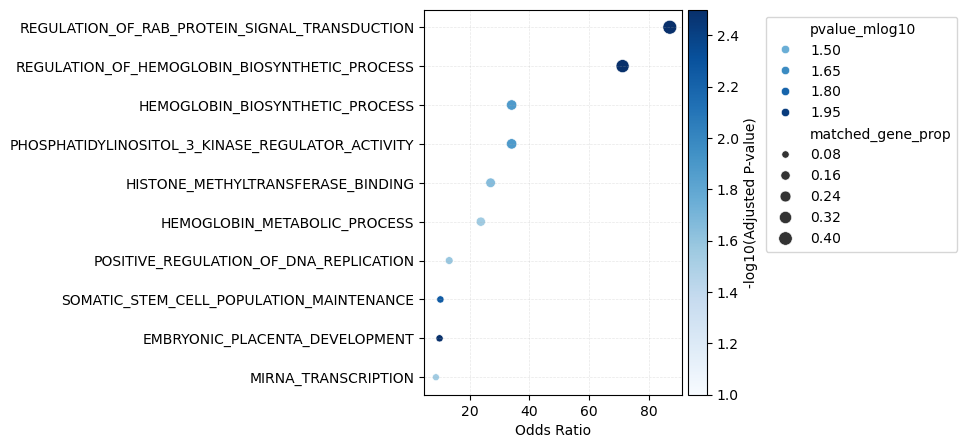

In [158]:
plt.figure(figsize=(4, 5))
go_comvar_sig = go_comvar_sig.sort_values(by=['Odds Ratio', 'Term'], ascending=[False, True]).reset_index(drop=True)
scatter = sns.scatterplot(
    data=go_comvar_sig.head(10),
    x='Odds Ratio',
    y='Term_split',
    size='matched_gene_prop',
    hue='pvalue_mlog10',
    palette='Blues',
    sizes=(25, 100),
    hue_norm=(1, 2),
    legend='brief'
)
norm = mpl.colors.Normalize(vmin=1, vmax=2.5)
sm = mpl.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', pad=0.02)
cbar.set_label('-log10(Adjusted P-value)', rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), ncol=1, frameon=True)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.3)
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'K562_comvar_go_enrichment.pdf'), dpi=300,
            bbox_inches='tight', transparent=True)
# plt.savefig('results/var2gene_results/K562_comvar_go_enrichment.pdf', dpi=300, bbox_inches='tight')

### Validate filtered comvar target genes against reference

In [159]:
# Compare filtered comvar results with reference
ref = pd.read_csv('data/results/K562_crediblevars_target_gene_full_for_go_enrichment.csv')
print(f"Our filtered: {len(comvar_filtered)} variants, {comvar_filtered['TargetGene'].nunique()} genes")
print(f"Reference:    {len(ref)} variants, {ref['TargetGene'].nunique()} genes")

our_ids = set(comvar_filtered['rsID'])
ref_ids = set(ref['rsID'])
shared = our_ids & ref_ids
only_ours = our_ids - ref_ids
only_ref = ref_ids - our_ids

print(f"\nShared rsIDs:       {len(shared)} / {len(ref_ids)} ({100*len(shared)/len(ref_ids):.1f}%)")
print(f"Only in ours:       {len(only_ours)}")
print(f"Only in reference:  {len(only_ref)}")

# Check gene agreement on shared rsIDs
our_genes = comvar_filtered.set_index('rsID')['TargetGene']
ref_genes = ref.set_index('rsID')['TargetGene']
matches = sum(our_genes[rid] == ref_genes[rid] for rid in shared)
print(f"Gene match (shared): {matches}/{len(shared)} ({100*matches/len(shared):.1f}%)")

if only_ref:
    print(f"\nrsIDs only in reference: {sorted(only_ref)}")
    for rid in sorted(only_ref):
        row = ref[ref['rsID'] == rid].iloc[0]
        print(f"  {rid} -> {row['TargetGene']} (ABC={row['ABC.Score']:.3f}, PIP={row['PIP']:.3f}, PEP_cs={row['PEP_cs']:.3f})")

Our filtered: 209 variants, 195 genes
Reference:    206 variants, 192 genes

Shared rsIDs:       205 / 206 (99.5%)
Only in ours:       4
Only in reference:  1
Gene match (shared): 205/205 (100.0%)

rsIDs only in reference: ['19:19432290_AG_A']
  19:19432290_AG_A -> SUGP1 (ABC=1.000, PIP=0.323, PEP_cs=0.772)


## GO Enrichment — rarevar target genes (from link_var2gene.py)

In [170]:
# Load rarevar ABC-FP-Max results (top gene per variant)
rarevar_max = pd.read_csv('results/var2gene_results/K562_rarevar_ABC-FP-Max.csv')
rarevar_filtered = rarevar_max[rarevar_max['ABC.Score'] > 0.015].reset_index(drop=True)
gene_list_rarevar = list(rarevar_filtered['TargetGene'].unique())
print(f"Total rarevar variants: {len(rarevar_max)}, after ABC.Score > 0.015: {len(rarevar_filtered)}")
print(f"Unique target genes: {len(gene_list_rarevar)}")

# GO enrichment
enr_rarevar = gp.enrichr(
    gene_list=gene_list_rarevar,
    gene_sets='data/GSEA_MSigDB/c5.go.v2025.1.Hs.symbols.gmt',
    organism='Human',
    cutoff=0.05,
)
res2d_rarevar = enr_rarevar.res2d
go_rarevar_sig = res2d_rarevar[res2d_rarevar['Adjusted P-value'] < 0.05].sort_values(
    by='Odds Ratio', ascending=False
).reset_index(drop=True)

go_rarevar_sig['Term_split'] = go_rarevar_sig['Term'].str.split('_').apply(
    lambda x: '_'.join(x[1:7]) + '\n' + '_'.join(x[7:]) if len(x) > 7 else '_'.join(x[1:])
)
go_rarevar_sig['matched_gene'] = go_rarevar_sig['Overlap'].str.split('/').str[0].astype(int)
go_rarevar_sig['total_gene'] = go_rarevar_sig['Overlap'].str.split('/').str[1].astype(int)
go_rarevar_sig['matched_gene_prop'] = go_rarevar_sig['matched_gene'] / go_rarevar_sig['total_gene']
go_rarevar_sig['pvalue_mlog10'] = -np.log10(go_rarevar_sig['Adjusted P-value'])
print(f"Significant GO terms: {go_rarevar_sig.shape[0]}")
go_rarevar_sig = go_rarevar_sig[go_rarevar_sig['matched_gene'] > 1].reset_index(drop=True)
go_rarevar_sig.head(15)

Total rarevar variants: 19, after ABC.Score > 0.015: 18
Unique target genes: 14
Significant GO terms: 37


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,Term_split,matched_gene,total_gene,matched_gene_prop,pvalue_mlog10
0,c5.go.v2025.1.Hs.symbols.gmt,GOMF_HAPTOGLOBIN_BINDING,3/10,2.131402e-08,0.000004,956.985965,16904.104981,HBQ1;HBZ;HBA2,HAPTOGLOBIN_BINDING,3,10,0.300000,5.387205
1,c5.go.v2025.1.Hs.symbols.gmt,GOCC_HAPTOGLOBIN_HEMOGLOBIN_COMPLEX,3/11,2.929663e-08,0.000004,844.356037,14646.025209,HBQ1;HBZ;HBA2,HAPTOGLOBIN_HEMOGLOBIN_COMPLEX,3,11,0.272727,5.387205
2,c5.go.v2025.1.Hs.symbols.gmt,GOCC_HEMOGLOBIN_COMPLEX,3/12,3.904865e-08,0.000004,755.437673,12886.601400,HBQ1;HBZ;HBA2,HEMOGLOBIN_COMPLEX,3,12,0.250000,5.387205
3,c5.go.v2025.1.Hs.symbols.gmt,GOMF_OXYGEN_CARRIER_ACTIVITY,3/14,6.456304e-08,0.000005,623.993135,10330.595583,HBQ1;HBZ;HBA2,OXYGEN_CARRIER_ACTIVITY,3,14,0.214286,5.293916
4,c5.go.v2025.1.Hs.symbols.gmt,GOBP_OXYGEN_TRANSPORT,3/15,8.067585e-08,0.000005,574.044211,9375.764529,HBQ1;HBZ;HBA2,OXYGEN_TRANSPORT,3,15,0.200000,5.293916
5,c5.go.v2025.1.Hs.symbols.gmt,GOBP_GAS_TRANSPORT,3/22,2.723955e-07,0.000014,367.844804,5560.346037,HBQ1;HBZ;HBA2,GAS_TRANSPORT,3,22,0.136364,4.844641
6,c5.go.v2025.1.Hs.symbols.gmt,GOBP_CARBON_DIOXIDE_TRANSPORT,2/15,3.628989e-05,0.000817,343.483245,3511.762902,HBZ;HBA2,CARBON_DIOXIDE_TRANSPORT,2,15,0.133333,3.088032
7,c5.go.v2025.1.Hs.symbols.gmt,GOBP_HYDROGEN_PEROXIDE_CATABOLIC_PROCESS,3/32,8.742918e-07,0.000038,243.026762,3390.187264,HBQ1;HBZ;HBA2,HYDROGEN_PEROXIDE_CATABOLIC_PROCESS,3,32,0.093750,4.421881
8,c5.go.v2025.1.Hs.symbols.gmt,GOMF_OXYGEN_BINDING,3/33,9.613879e-07,0.000038,235.046592,3256.544176,HBQ1;HBZ;HBA2,OXYGEN_BINDING,3,33,0.090909,4.421881
9,c5.go.v2025.1.Hs.symbols.gmt,GOBP_ONE_CARBON_COMPOUND_TRANSPORT,2/25,1.033314e-04,0.001808,197.218845,1809.989525,HBZ;HBA2,ONE_CARBON_COMPOUND_TRANSPORT,2,25,0.080000,2.742729


/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_55480/1408115499.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


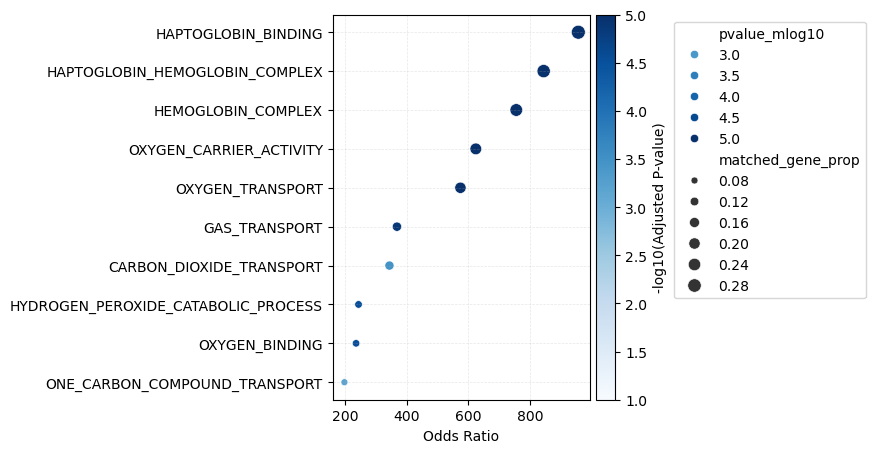

In [171]:
plt.figure(figsize=(4, 5))
scatter = sns.scatterplot(
    data=go_rarevar_sig.head(10),
    x='Odds Ratio',
    y='Term_split',
    size='matched_gene_prop',
    hue='pvalue_mlog10',
    palette='Blues',
    sizes=(25, 100),
    hue_norm=(0, 5),
    legend='brief'
)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
sm = mpl.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', pad=0.02)
cbar.set_label('-log10(Adjusted P-value)', rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), ncol=1, frameon=True)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.3)
plt.ylabel('')
plt.tight_layout()
#$ plt.savefig('results/var2gene_results/K562_rarevar_go_enrichment.pdf', dpi=300, bbox_inches='tight')

In [82]:
# === Data preparation for 4-panel figure ===

# Explicit rsID order (bottom to top: strongest to weakest AlphaGenome effect)
rsid_order = [
    'rs112233623', 'rs11735662', 'rs115730158', 'rs4669320',
    'rs538053479', 'rs10411508', 'rs17215231', 'rs7115200',
    'rs2071646', 'rs1991401', 'rs77685055', 'rs13082210',
    'rs185354376', 'rs117532831', 'rs62078819', 'rs61750991',
    'rs2278744', 'rs28595855', 'rs893907', 'rs533281866',
    'rs11122174', 'rs76402227', 'rs41307187', 'rs12277563',
    'rs150182213', 'rs150817108', 'rs114694170', 'rs148139592',
    'rs57565032', 'rs2703485',
]

# Load AlphaGenome TF ChIP scores (all TFs for PIP>0.7 variants)
alphag_pred = pd.read_csv('results/K562_comvar_pip70_alphag_tf_chip.csv')
pip70_rsids = set(alphag_pred['rsID'].unique())

# Filter to only hardcoded rsIDs present in data
rsid_order = [r for r in rsid_order if r in pip70_rsids]
# Filter alphag_pred to only these variants
alphag_pred = alphag_pred[alphag_pred['rsID'].isin(rsid_order)].reset_index(drop=True)

# Load target gene + ABC.Score
abc_max = pd.read_csv('results/var2gene_results/K562_comvar_ABC-FP-Max.csv')
rsid_to_gene = dict(zip(abc_max['rsID'], abc_max['TargetGene']))
rsid_to_abc = dict(zip(abc_max['rsID'], abc_max['ABC.Score']))

# Load H3K27ac scores from comvar2grn (one per variant)
grn = pd.read_csv('results/K562_comvar2grn.csv')
h3k27ac_lookup = grn.drop_duplicates('rsID').set_index('rsID')['alphag_H3K27ac_score'].to_dict()

# Load per-trait PIP and A1Effect for PIP>0.7 variants
cs_dir = 'data/GWFM_erythroids/credible_set_snpRes'
trait_rows = []
for f in sorted(glob.glob(os.path.join(cs_dir, '*_credible_set_hg38.csv'))):
    trait = os.path.basename(f).replace('_credible_set_hg38.csv', '')
    df = pd.read_csv(f, usecols=['Name', 'PIP', 'A1Effect'])
    df = df[df['Name'].isin(set(rsid_order))]
    df['trait'] = trait
    trait_rows.append(df)
trait_df = pd.concat(trait_rows).rename(columns={'Name': 'rsID'})
trait_df['effect_direction'] = trait_df['A1Effect'] > 0
trait_df['TargetGene'] = trait_df['rsID'].map(rsid_to_gene)

# Trait order (from reference figure)
trait_order = ['HLDRC', 'RC', 'RP', 'HLSRP', 'HC', 'HP', 'RBCDW', 'MCHC', 'IRF', 'MCV', 'MCH', 'MSCV', 'RBC']
trait_df['trait'] = pd.Categorical(trait_df['trait'], categories=trait_order, ordered=True)

# Gene labels for y-axis (in rsid_order)
gene_labels = [rsid_to_gene.get(r, r) for r in rsid_order]

# Build heatmap DataFrames
heatmap_h3k27ac = pd.DataFrame({
    'rsID': rsid_order,
    'raw_score': [h3k27ac_lookup.get(r, np.nan) for r in rsid_order]
}).set_index('rsID')

heatmap_abc = pd.DataFrame({
    'rsID': rsid_order,
    'ABC.Score': [rsid_to_abc.get(r, np.nan) for r in rsid_order]
}).set_index('rsID')

# Categorical rsID for bubble and scatter plots
trait_df['rsID_cat'] = pd.Categorical(trait_df['rsID'], categories=rsid_order, ordered=True)

# Split AlphaGenome TF ChIP by TF_change
no_change = alphag_pred[alphag_pred['TF_change'].isna()].copy()
decreased = alphag_pred[alphag_pred['TF_change'] == 'Decrease'].copy()
increased = alphag_pred[alphag_pred['TF_change'] == 'Increase'].copy()
disrupted = alphag_pred[alphag_pred['TF_change'] == 'Disrupt'].copy()
created = alphag_pred[alphag_pred['TF_change'] == 'Create'].copy()
for df in [no_change, decreased, increased, disrupted, created]:
    df['rsID'] = pd.Categorical(df['rsID'], categories=rsid_order, ordered=True)

print(f'Variants: {len(rsid_order)}, Traits: {len(trait_order)}')

Variants: 30, Traits: 13


Text(0.5, 1.0, 'Quantile Score')

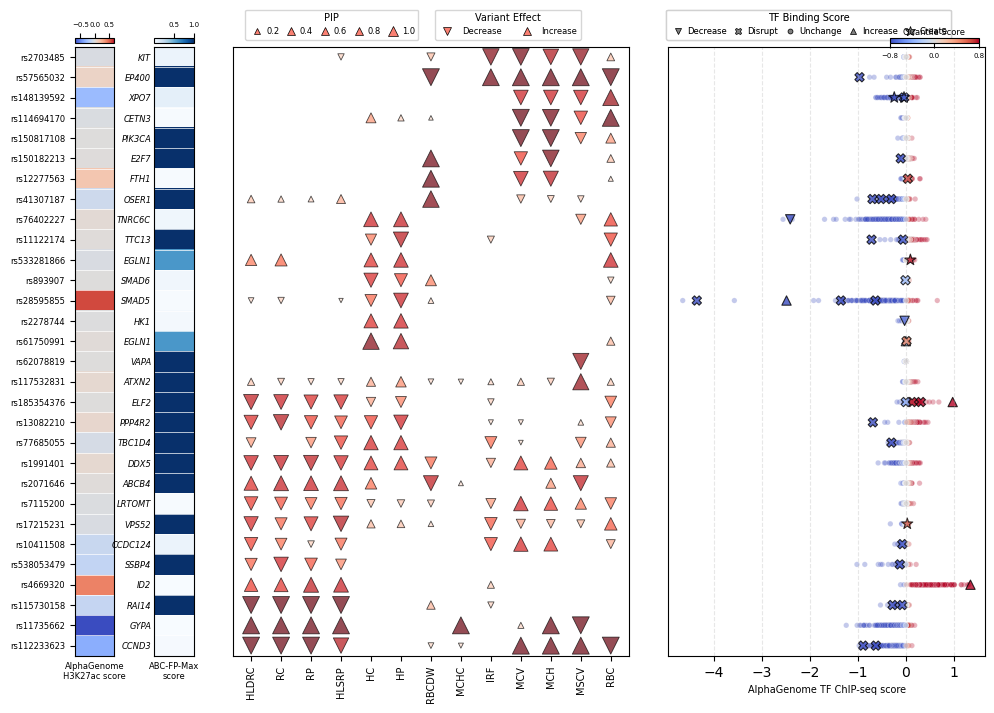

In [83]:
# === 4-panel composite figure ===
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

n = len(rsid_order)

# Ensure alphag_pred has categorical rsID for correct ordering
alphag_pred['rsID'] = pd.Categorical(alphag_pred['rsID'], categories=rsid_order, ordered=True)

fig, axes = plt.subplots(1, 4, figsize=(10, 7),
                         gridspec_kw={'width_ratios': [0.5, 0.5, 5, 4],
                                      'wspace': 0.2})

# --- Panel 0: AlphaGenome H3K27ac heatmap ---
vals0 = heatmap_h3k27ac.values
vmax0 = np.nanmax(np.abs(vals0))
im0 = axes[0].imshow(vals0, cmap='coolwarm', aspect='auto', origin='lower',
                      interpolation='nearest', vmin=-vmax0, vmax=vmax0)
for i in range(n + 1):
    axes[0].axhline(i - 0.5, color='white', linewidth=0.5)
axes[0].set_yticks(range(n))
axes[0].set_yticklabels(rsid_order, fontsize=6)
axes[0].set_xticks([])
axes[0].set_xlabel('AlphaGenome\nH3K27ac score', fontsize=6)
axes[0].set_ylim(-0.5, n - 0.5)
axes[0].set_ylabel('')

# --- Panel 1: ABC-FP-Max score heatmap ---
vals1 = heatmap_abc.values
im1 = axes[1].imshow(vals1, cmap='Blues', aspect='auto', origin='lower',
                      interpolation='nearest')
for i in range(n + 1):
    axes[1].axhline(i - 0.5, color='white', linewidth=0.5)
axes[1].set_yticks(range(n))
axes[1].set_yticklabels(gene_labels, fontsize=6)
for label in axes[1].get_yticklabels():
    label.set_fontstyle('italic')
axes[1].tick_params(axis='y', length=0, pad=2)
axes[1].set_xticks([])
axes[1].set_xlabel('ABC-FP-Max\nscore', fontsize=6)
axes[1].set_ylim(-0.5, n - 0.5)

# --- Panel 2: PIP bubble plot by trait ---
marker_map = {False: 'v', True: '^'}
sns.scatterplot(
    data=trait_df, x='trait', y='rsID_cat',
    hue='PIP', size='PIP', alpha=0.7, sizes=(10, 150),
    style='effect_direction', markers=marker_map,
    linewidth=0.6, hue_norm=(0, 1), edgecolors='black',
    palette='Reds', ax=axes[2], legend=False)
axes[2].set_yticks([])
axes[2].set_ylabel('')
axes[2].set_xlabel('')
axes[2].set_ylim(-0.5, n - 0.5)
axes[2].tick_params(axis='x', labelrotation=90, labelsize=7)

# --- Panel 3: AlphaGenome TF ChIP-seq scatter ---
norm_q = Normalize(vmin=-1.0, vmax=1.0)
sns.scatterplot(data=no_change, y='rsID', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='o', s=15, ax=axes[3], alpha=0.3, legend=False)
sns.scatterplot(data=decreased, y='rsID', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='v', s=45, ax=axes[3], alpha=0.8, linewidth=0.8,
                edgecolors='black', legend=False)
sns.scatterplot(data=increased, y='rsID', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='^', s=45, ax=axes[3], alpha=0.8, linewidth=0.8,
                edgecolors='black', legend=False)
sns.scatterplot(data=disrupted, y='rsID', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='X', s=45, ax=axes[3], alpha=0.8, linewidth=0.8,
                edgecolors='black', legend=False)
sns.scatterplot(data=created, y='rsID', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='*', s=70, ax=axes[3], alpha=0.8, linewidth=0.8,
                edgecolors='black', legend=False)
axes[3].grid(axis='x', linestyle='--', alpha=0.3)
axes[3].set_ylabel('')
axes[3].set_yticks([])
axes[3].set_ylim(-0.5, n - 0.5)
axes[3].set_xlabel('AlphaGenome TF ChIP-seq score', fontsize=7)

# === Layout, then add colorbars & legends ===
fig.subplots_adjust(left=0.07, right=0.98, bottom=0.08, top=0.95, wspace=0.08)

# --- Colorbars directly above heatmaps ---
pos0 = axes[0].get_position()
cax0 = fig.add_axes([pos0.x0, pos0.y1 + 0.005, pos0.width, 0.008])
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal')
cax0.xaxis.set_ticks_position('top')
cax0.tick_params(labelsize=5)

pos1 = axes[1].get_position()
cax1 = fig.add_axes([pos1.x0, pos1.y1 + 0.005, pos1.width, 0.008])
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position('top')
cax1.tick_params(labelsize=5)

# --- Custom legends above panels 2 & 3 ---
pip_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
pip_handles = []
for s in pip_sizes:
    ms = np.sqrt(10 + (150 - 10) * s) * 0.4 + 2
    pip_handles.append(Line2D([0], [0], marker='^', color='w', markerfacecolor='salmon',
                              markeredgecolor='black', markersize=ms, linestyle='',
                              markeredgewidth=0.5))
leg_pip = axes[2].legend(pip_handles, [str(s) for s in pip_sizes], title='PIP',
                         loc='lower left', bbox_to_anchor=(0.02, 1.005), ncol=5,
                         fontsize=6, title_fontsize=7, frameon=True,
                         handletextpad=0.1, columnspacing=0.4)
axes[2].add_artist(leg_pip)

ve_handles = [
    Line2D([0], [0], marker='v', color='w', markerfacecolor='salmon',
           markeredgecolor='black', markersize=6, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='salmon',
           markeredgecolor='black', markersize=6, linestyle='', markeredgewidth=0.5),
]
axes[2].legend(ve_handles, ['Decrease', 'Increase'], title='Variant Effect',
               loc='lower left', bbox_to_anchor=(0.50, 1.005), ncol=2,
               fontsize=6, title_fontsize=7, frameon=True)

tf_handles = [
    Line2D([0], [0], marker='v', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=5, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=5, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=3.5, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=5, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=7, linestyle='', markeredgewidth=0.5),
]
leg_tf = axes[3].legend(tf_handles, ['Decrease', 'Disrupt', 'Unchange', 'Increase', 'Create'],
                        title='TF Binding Score', loc='lower left',
                        bbox_to_anchor=(-0.02, 1.005), ncol=5, fontsize=6,
                        title_fontsize=7, frameon=True, handletextpad=0.1,
                        columnspacing=0.4)
axes[3].add_artist(leg_tf)

# Quantile Score colorbar
pos3 = axes[3].get_position()
cax_q = fig.add_axes([pos3.x0 + pos3.width * 0.7, pos3.y1 + 0.005, pos3.width * 0.28, 0.008])
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=Normalize(vmin=-0.8, vmax=0.8))
sm.set_array([])
cb_q = fig.colorbar(sm, cax=cax_q, orientation='horizontal')
cb_q.set_ticks([-0.8, 0, 0.8])
cax_q.tick_params(labelsize=5)
cax_q.set_title('Quantile Score', fontsize=6, pad=2)

# plt.savefig('results/figures/figure4_comvar2grn.pdf', transparent=True, format='pdf', bbox_inches='tight')

In [86]:
df = alphag_pred[~alphag_pred['TF_motif'].isna()].copy()
df['rsID'] = pd.Categorical(df['rsID'], categories=rsid_order[::-1], ordered=True)
df.sort_values('rsID').dropna(subset=['rsID'])

,rsID,max_PIP,TF_motif,TF_change,p-value_ref,p-value_alt,TF_alphag,TF_alphag_K562_rna_tpm,alphag_TF_chip_score,alphag_TF_chip_quantile
6190,rs57565032,1.000000,CTCF,Disrupt,5.679651e-05,NaN,CTCF,5.050660,-0.966440,-0.998668
2644,rs148139592,0.903005,CEBPG,Create,NaN,7.247925e-05,CEBPG,6.684640,-0.042187,-0.923901
2460,rs148139592,0.903005,ATF4,Create,NaN,6.961823e-05,ATF4,76.479500,-0.244925,-0.996876
2649,rs148139592,0.903005,MGA::EVX1,Disrupt,3.099442e-06,NaN,MGA,2.711040,-0.040458,-0.913094
2691,rs150182213,0.986471,SP1,Disrupt,3.814697e-05,NaN,SP1,4.276220,-0.110984,-0.989427
1938,rs12277563,0.988337,REST,Disrupt,5.150686e-05,NaN,REST,3.178600,0.035985,0.889375
5111,rs41307187,0.953940,GATA2,Disrupt,6.103516e-05,NaN,GATA2,9.177150,-0.698190,-0.999483
5118,rs41307187,0.953940,GATA1::TAL1,Disrupt,3.827253e-05,NaN,TAL1,10.191100,-0.518954,-0.998637
5137,rs41307187,0.953940,GATA1::TAL1,Disrupt,3.827253e-05,NaN,GATA1,47.767200,-0.306703,-0.996574
7278,rs76402227,0.773832,CTCF,Decrease,1.798384e-06,5.651917e-05,CTCF,5.050660,-2.407624,-0.999753


In [100]:
var2tfbs_extra = pd.read_csv('./results/K562_comvar_var2tfbsExtra.csv')
var2tfbs_extra['rsID'] = pd.Categorical(var2tfbs_extra['rsID'], categories=rsid_order[::-1], ordered=True)
var2tfbs_extra.drop_duplicates(subset=['rsID', 'TF']).sort_values(['rsID', 'TF_K562_rna_tpm']).dropna(subset=['rsID'])[['rsID', 'TF', 'TF_change', 'TF_K562_rna_tpm']].tail(50)

,rsID,TF,TF_change,TF_K562_rna_tpm
111,rs117532831,CTCFL,Create,20.817400
210,rs185354376,ZNF610,Create,0.034956
194,rs185354376,PRDM9,Decrease,0.089618
214,rs185354376,ZNF701,Create,0.792934
198,rs185354376,ZNF320,Disrupt,0.930875
218,rs185354376,ZNF93,Increase,1.477950
206,rs185354376,ZNF530,Decrease,1.851530
202,rs185354376,ZNF460,Disrupt,3.650610
119,rs13082210,EGR2,Increase,0.000000
125,rs13082210,EGR4,Increase,0.000000


In [102]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import Normalize, ListedColormap
from scipy.cluster.hierarchy import fcluster
from tqdm import tqdm
import gseapy as gp

# PDF-friendly fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Paths
PROJECT_ROOT = '.'
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')
FIG_DIR = os.path.join(RESULTS_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

# Color palettes
TF_CHANGE_PALETTE = {
    'Disrupt': '#1f458d', 'Decrease': '#6e9dc3',
    'Create': '#2d6533', 'Increase': '#82b376'
}
TF_CHANGE_ORDER = ['Create', 'Increase', 'Disrupt', 'Decrease']
MANHATTAN_COLORS = ['#234895', '#71a4cc']

In [105]:
# Load credible set variant info from footprint overlap results
cs_dir = os.path.join(RESULTS_DIR, 'comvar_footprint_overlap_credible', 'K562.merged.hg38')
cs_frames = []
for fn in sorted(glob.glob(os.path.join(cs_dir, '*_K562.merged.hg38.csv'))):
    df = pd.read_csv(fn)
    trait = os.path.basename(fn).split('_')[0]
    df['trait'] = trait
    cs_frames.append(df)
snp_cs = pd.concat(cs_frames).reset_index(drop=True)
snp_cs = snp_cs.rename(columns={'SNP': 'rsID'})

# Deduplicated: keep highest PEP_cs per rsID
snp_cs_dedup = (
    snp_cs.sort_values(by=['rsID', 'PEP_cs'], ascending=[True, False])
    .drop_duplicates(subset=['rsID'])
    .reset_index(drop=True)
)

print(f'Credible set variants (all traits): {snp_cs["rsID"].nunique():,}')
print(f'With PEP_cs >= 0.7: {snp_cs_dedup[snp_cs_dedup["PEP_cs"] >= 0.7].shape[0]:,}')
# Load all erythroid trait fine-mapping variants overlapping K562 FOODIE footprints
allvars_dir = os.path.join(DATA_DIR, 'GWFM_erythroids', 'allvars_hg38_K562_foodie')
all_comvar_K562 = []
for fn in sorted(glob.glob(os.path.join(allvars_dir, '*_finemapping_allvars_hg38_K562_foodie.tsv'))):
    df = pd.read_csv(fn, sep='\t')
    df['trait'] = os.path.basename(fn).split('_')[0]
    all_comvar_K562.append(df)
all_comvar_K562 = pd.concat(all_comvar_K562).reset_index(drop=True)
all_comvar_K562['GENPOS'] = all_comvar_K562['End'].astype(int)
all_comvar_K562['CHROM'] = all_comvar_K562['Chromosome'].str.replace('chr', '').astype(int)
all_comvar_K562 = all_comvar_K562.rename(columns={'Position': 'Position_hg19'})

# Keep top PIP per variant (across traits)
all_comvar_K562_keepTopPIP = (
    all_comvar_K562[['Name', 'trait', 'PIP', 'A1Effect']]
    .sort_values(by=['Name', 'PIP'], ascending=[True, False])
    .drop_duplicates(subset=['Name'], keep='first')
    .reset_index(drop=True)
)

print(f'Traits loaded: {sorted(all_comvar_K562["trait"].unique())}')
print(f'Total variant-trait rows: {len(all_comvar_K562):,}')
print(f'Unique variants: {all_comvar_K562["Name"].nunique():,}')
# Load VAR2TFBS results
var2tfbs = pd.read_csv(os.path.join(RESULTS_DIR, 'comvar_var2tfbs_results', 'K562_var2tfbs.csv'))

# Load TF expression
tf_expr = pd.read_csv(os.path.join(DATA_DIR, 'gene_expr', 'TF_K562_GM12878_expression.csv'))
var2tfbs = var2tfbs.merge(
    tf_expr[['TF', 'K562_rna_tpm']].rename(columns={'K562_rna_tpm': 'TF_K562_rna_tpm'}),
    on='TF', how='left'
)

# Merge with PIP and PEP_cs
var_tfbs_alt_ref_pip = var2tfbs.merge(
    all_comvar_K562_keepTopPIP.rename(columns={'Name': 'rsID'}), on='rsID'
)
var_tfbs_alt_ref_pip_cs = var_tfbs_alt_ref_pip.merge(
    snp_cs_dedup[['rsID', 'PEP_cs', 'CS_id']].drop_duplicates(), on='rsID', how='left'
).reset_index(drop=True)

# Filter: PIP >= 0.1, in credible set
var_tfbs_alt_ref_filtered = var_tfbs_alt_ref_pip_cs[
    (var_tfbs_alt_ref_pip_cs['PIP'] >= 0.1) & (~var_tfbs_alt_ref_pip_cs['PEP_cs'].isna())
].reset_index(drop=True)

# TF change event counts for bar chart
var_tfbs_change_event_count = (
    var_tfbs_alt_ref_filtered.groupby('TF_change').size()
    .reset_index(name='count')
)

# Affected variants (exclude Unchange)
var_tfbs_alt_ref_effected = var_tfbs_alt_ref_filtered[
    var_tfbs_alt_ref_filtered['TF_change'] != 'Unchange'
].reset_index(drop=True)

# TF-level counts for box/strip plot
TF_change_event_count = (
    var_tfbs_alt_ref_effected.groupby(['TF', 'TF_change']).size()
    .reset_index().rename(columns={0: 'count'})
)

print(f'VAR2TFBS total rsIDs: {var2tfbs["rsID"].nunique()}')
print(f'Filtered (PIP>=0.1, in CS): {var_tfbs_alt_ref_filtered["rsID"].nunique()} rsIDs')
print(f'With TF effect (excl Unchange): {var_tfbs_alt_ref_effected["rsID"].nunique()} rsIDs')

Credible set variants (all traits): 961
With PEP_cs >= 0.7: 229
Traits loaded: ['HC', 'HLDRC', 'HLSRP', 'HP', 'IRF', 'MCH', 'MCHC', 'MCV', 'MSCV', 'RBC', 'RBCDW', 'RC', 'RP']
Total variant-trait rows: 208,819
Unique variants: 16,063
VAR2TFBS total rsIDs: 847
Filtered (PIP>=0.1, in CS): 207 rsIDs
With TF effect (excl Unchange): 204 rsIDs


In [108]:
# Load ABC-FP-Max gene assignments
var2gene = pd.read_csv(os.path.join(RESULTS_DIR, 'var2gene_results', 'K562_comvar_ABC-FP-Max.csv'))

# Merge with TFBS-affected variants to get PIP and PEP_cs
affected_rsids = var_tfbs_alt_ref_effected[['rsID', 'foodie_id']].drop_duplicates()
K562_fp_atac_gene_var = var2gene.merge(affected_rsids, on=['rsID', 'foodie_id']).reset_index(drop=True)

# Add PIP and PEP_cs
K562_fp_atac_gene_var = K562_fp_atac_gene_var.merge(
    all_comvar_K562_keepTopPIP[['Name', 'PIP']].rename(columns={'Name': 'rsID'}),
    on='rsID', how='left'
)
K562_fp_atac_gene_var = K562_fp_atac_gene_var.merge(
    snp_cs_dedup[['rsID', 'PEP_cs']].drop_duplicates(), on='rsID', how='left'
)

# Deduplicate: keep best ABC score per variant
K562_fp_atac_gene_var_dedup = (
    K562_fp_atac_gene_var
    .sort_values(by=['rsID', 'ABC.Score'], ascending=[True, False])
    .drop_duplicates(subset=['rsID'], keep='first')
    .reset_index(drop=True)
)

# Filter: ABC > 0.015, PIP > 0.1, in credible set
K562_fp_atac_gene_var_filtered = K562_fp_atac_gene_var_dedup[
    (K562_fp_atac_gene_var_dedup['ABC.Score'] > 0.015) &
    (K562_fp_atac_gene_var_dedup['PIP'] > 0.1) &
    (~K562_fp_atac_gene_var_dedup['PEP_cs'].isna())
].reset_index(drop=True)

print(f'Variant-gene pairs (filtered): {len(K562_fp_atac_gene_var_filtered)}')
print(f'Unique genes: {K562_fp_atac_gene_var_filtered["TargetGene"].nunique()}')

Variant-gene pairs (filtered): 189
Unique genes: 177


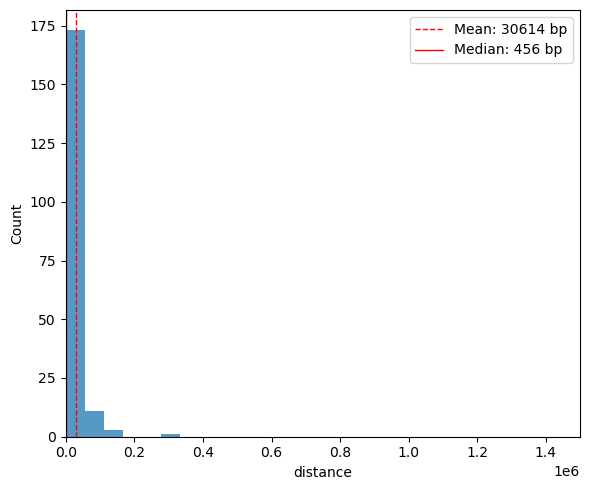

In [110]:
mean_dist = np.mean(K562_fp_atac_gene_var_filtered['distance'])
median_dist = np.median(K562_fp_atac_gene_var_filtered['distance'])

plt.figure(figsize=(6, 5))
sns.histplot(K562_fp_atac_gene_var_filtered['distance'], lw=0, bins=60)
plt.axvline(x=mean_dist, color='r', lw=1, linestyle='--',
            label=f'Mean: {mean_dist:.0f} bp')
plt.axvline(x=median_dist, color='r', lw=1, linestyle='-',
            label=f'Median: {median_dist:.0f} bp')
plt.xlim([-1, 1_500_000])
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure4_K562_fp_atac_gene_var_distance.pdf'),
            transparent=True, dpi=500)
plt.show()

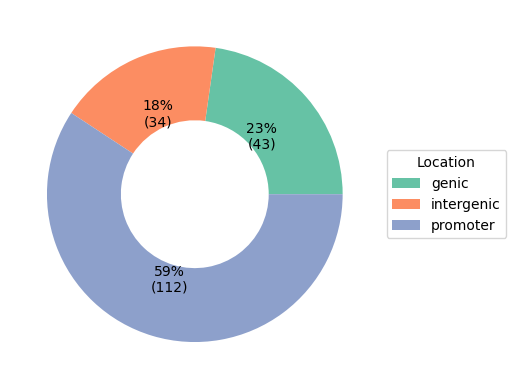

In [111]:
cre_counts = K562_fp_atac_gene_var_filtered.groupby('class').size().reset_index(name='count')
labels = cre_counts['class'].tolist()
data = cre_counts['count'].tolist()
colors = sns.color_palette('Set2')

def autopct_format_cre(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))
    return f"{pct:.0f}%\n({absolute})"

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    data, colors=colors, startangle=0,
    autopct=lambda pct: autopct_format_cre(pct, data),
    wedgeprops=dict(width=0.5)
)
ax.legend(wedges, labels, title='Location', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig(os.path.join(FIG_DIR, 'figure4_common_pep70_tfbs_cre_type.pdf'),
            bbox_inches='tight', transparent=True)
plt.show()

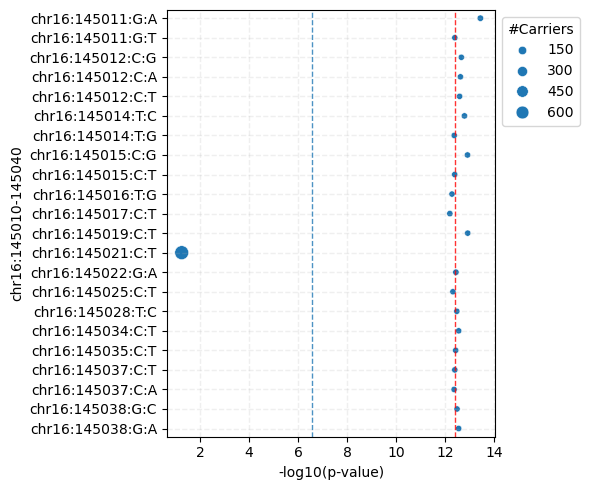

In [ ]:
def plot_loo(trait, fp_id,
             loo_path='data/leaveoneout_results/K562.leave_one_out.all_traits.20251120.csv',
             carrier_path='data/leaveoneout_results/K562_foodie_carray-20251117.xlsx',
             driver_path='results/rarevar_var2tfbs_results/driver_variants_summary.csv',
             var_carriers=None, figsize=(6, 5), save_path=None):
    """Plot leave-one-out results for a specific footprint and trait.

    Parameters
    ----------
    trait : str
        Trait name (e.g. 'MCV')
    fp_id : str
        Footprint ID (e.g. 'chr16:145010-145040')
    var_carriers : DataFrame, optional
        Pre-loaded carrier counts with 'site' and '#carriers' columns.
        If None, loads from carrier_path Excel.
    """
    # Load LOO data (CSV, all traits — faster than per-trait XLSX)
    loo = pd.read_csv(loo_path)
    fp_loo = loo[(loo['foodie'] == fp_id) & (loo['trait'] == trait)].copy()
    if fp_loo.empty:
        print(f'No LOO data for footprint={fp_id}, trait={trait}')
        return None

    # Carrier counts: merge before stripping DRAGEN prefix
    if var_carriers is None:
        carray_df = pd.read_excel(carrier_path, sheet_name='rare_site_carray')
        var_carriers = carray_df.groupby('site')['IID'].count().reset_index().rename(columns={'IID': '#carriers'})
    fp_loo = fp_loo.merge(var_carriers[['site', '#carriers']], left_on='ID_rare', right_on='site', how='left')
    fp_loo = fp_loo.drop(columns=['site'])

    # Burden test p-value (full model, all variants included)
    drivers = pd.read_csv(driver_path)
    burden_row = drivers[(drivers['footprint'] == fp_id) & (drivers['trait'] == trait)]
    mlog10p_fp = -np.log10(burden_row['burden_p'].values[0]) if len(burden_row) > 0 else None

    # LOO effect: True = removing this variant doesn't reduce significance
    if mlog10p_fp is not None:
        fp_loo['Loo_effect'] = fp_loo['LOG10P'] >= mlog10p_fp

    # Clean variant labels for ßdisplay
    fp_loo['ID_rare'] = fp_loo['ID_rare'].str.replace('DRAGEN:', '')

    # Sort by genomic position
    fp_loo = fp_loo.sort_values(by='GENPOS', ascending=True).reset_index(drop=True)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(
        data=fp_loo, y='ID_rare', x='LOG10P',
        size='#carriers', sizes=(20, 100), ax=ax,
    )

    # Significance lines
    if mlog10p_fp is not None:
        ax.axvline(x=mlog10p_fp, color='red', linestyle='--', linewidth=1, alpha=0.8)
    ax.axvline(x=-np.log10(0.05 / 177270), linestyle='--', linewidth=1, alpha=0.8)

    ax.grid(linewidth=1, linestyle='--', alpha=0.2)
    ax.set_xlabel('-log10(p-value)')
    ax.margins(y=0.02)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='#Carriers')
    ax.set_ylabel(fp_id)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    return fp_loo

# Example
fp_trait_loo = plot_loo('MCV', 'chr16:145010-145040')

ABC.Score > 0.015: 18, TFBS altered: 19, both: 18
Heatmap: 18 variants × 13 traits


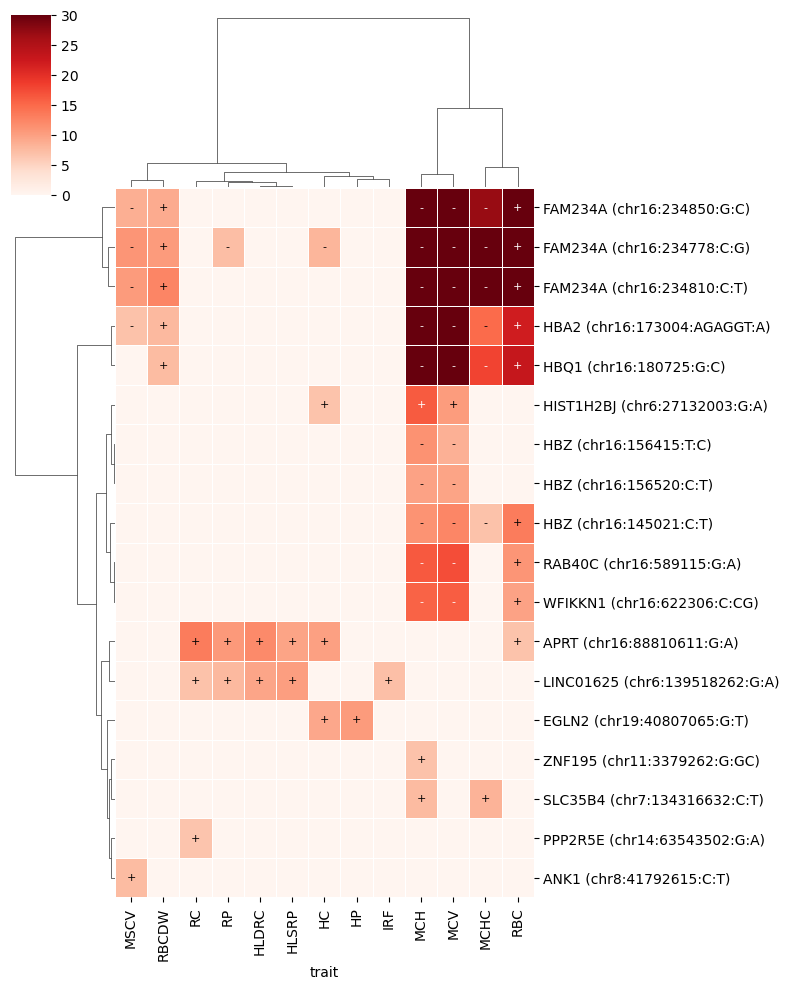


Row clusters:
1    3
2    2
3    6
4    7

Column clusters:
1    9
2    2
3    2


In [177]:
# === Rare variant (driver) × Trait clustered heatmap ===

# Load rare variant results
drivers_rv = pd.read_csv(os.path.join(RESULTS_DIR, 'rarevar_var2tfbs_results', 'driver_variants_summary.csv'))
abc_rv = pd.read_csv(os.path.join(RESULTS_DIR, 'var2gene_results', 'K562_rarevar_ABC-FP-Max.csv'))
var2tfbs_rv = pd.read_csv(os.path.join(RESULTS_DIR, 'rarevar_var2tfbs_results', 'K562_rarevar_var2tfbs.csv'))

# Load burden test effect direction (BETA) per footprint-trait
sig_annot = pd.read_csv(os.path.join(DATA_DIR, 'results', 'K562_rareVar_sig_annot.csv'))
fp_trait_beta = (sig_annot.drop_duplicates(subset=['Name_foodie', 'Trait'])
                 .set_index(['Name_foodie', 'Trait'])['BETA'].to_dict())

# Erythroid traits (from driver summary)
erythroid_traits = sorted(drivers_rv['trait'].unique())

# Filter 1: ABC.Score > 0.015
abc_pass = set(abc_rv[abc_rv['ABC.Score'] > 0.015]['rsID'])

# Filter 2: has TFBS alteration (any TF_change != Unchange)
tfbs_affected = set(var2tfbs_rv[var2tfbs_rv['TF_change'] != 'Unchange']['rsID'])

# Keep variants passing both filters
keep_variants = abc_pass & tfbs_affected
print(f'ABC.Score > 0.015: {len(abc_pass)}, TFBS altered: {len(tfbs_affected)}, both: {len(keep_variants)}')

# Map footprint -> TargetGene for y-axis label
fp_to_gene = dict(zip(abc_rv['foodie_id'], abc_rv['TargetGene']))

# Build variant × trait matrix (values = burden test -log10(p))
entries = []
for _, row in drivers_rv.iterrows():
    if row['driver_variant'] not in keep_variants:
        continue
    gene = fp_to_gene.get(row['footprint'], '')
    var_label = row['driver_variant'].replace('DRAGEN:', '')
    beta = fp_trait_beta.get((row['footprint'], row['trait']), 0)
    entries.append({
        'variant': var_label,
        'gene': gene,
        'trait': row['trait'],
        'logp': -np.log10(row['burden_p']),
        'direction': '+' if beta > 0 else '-',
    })

rv_df = pd.DataFrame(entries)

# Pivot to matrices
rv_mat = rv_df.pivot_table(index='variant', columns='trait', values='logp', aggfunc='max')
rv_dir = rv_df.pivot_table(index='variant', columns='trait', values='direction', aggfunc='first')
rv_mat = rv_mat.reindex(columns=erythroid_traits).fillna(0)
rv_dir = rv_dir.reindex(columns=erythroid_traits).fillna('')

# Add gene annotation as row label: "gene (variant)"
var_to_gene = rv_df.drop_duplicates('variant').set_index('variant')['gene']
new_index = [f'{var_to_gene.get(v, "")} ({v})' for v in rv_mat.index]
rv_mat.index = new_index
rv_dir.index = new_index

print(f'Heatmap: {rv_mat.shape[0]} variants × {rv_mat.shape[1]} traits')

# Hierarchical clustered heatmap
cg = sns.clustermap(
    rv_mat,
    method='ward',
    metric='euclidean',
    vmin=0,
    vmax=30,
    linewidths=0.5,
    cmap='Reds',
    figsize=(8, 10),
)

# Annotate significant cells with effect direction (+ or -)
reordered_dir = rv_dir.loc[cg.data2d.index, cg.data2d.columns]
for i in range(reordered_dir.shape[0]):
    for j in range(reordered_dir.shape[1]):
        if cg.data2d.iloc[i, j] > 0:
            cg.ax_heatmap.text(
                j + 0.5, i + 0.5, reordered_dir.iloc[i, j],
                ha='center', va='center', fontsize=8,
                color='white' if cg.data2d.iloc[i, j] > 15 else 'black',
            )

plt.show()

# Cluster labels
k_rows = min(4, rv_mat.shape[0])
k_cols = min(3, rv_mat.shape[1])

row_labels = fcluster(cg.dendrogram_row.linkage, t=k_rows, criterion='maxclust')
col_labels = fcluster(cg.dendrogram_col.linkage, t=k_cols, criterion='maxclust')

row_labels = pd.Series(row_labels, index=rv_mat.index)
col_labels = pd.Series(col_labels, index=rv_mat.columns)

print(f'\nRow clusters:\n{row_labels.value_counts().sort_index().to_string()}')
print(f'\nColumn clusters:\n{col_labels.value_counts().sort_index().to_string()}')

In [178]:
row_labels

ZNF195 (chr11:3379262:G:GC)       4
PPP2R5E (chr14:63543502:G:A)      4
HBZ (chr16:145021:C:T)            3
HBZ (chr16:156415:T:C)            3
HBZ (chr16:156520:C:T)            3
HBA2 (chr16:173004:AGAGGT:A)      2
HBQ1 (chr16:180725:G:C)           2
FAM234A (chr16:234778:C:G)        1
FAM234A (chr16:234810:C:T)        1
FAM234A (chr16:234850:G:C)        1
RAB40C (chr16:589115:G:A)         3
WFIKKN1 (chr16:622306:C:CG)       3
APRT (chr16:88810611:G:A)         4
EGLN2 (chr19:40807065:G:T)        4
LINC01625 (chr6:139518262:G:A)    4
HIST1H2BJ (chr6:27132003:G:A)     3
SLC35B4 (chr7:134316632:C:T)      4
ANK1 (chr8:41792615:C:T)          4
dtype: int32

In [181]:
# === Rare variant AlphaGenome TF ChIP scores — following clustermap row order ===

# Get clustered row order from the clustermap dendrogram
# cg.data2d.index is top-to-bottom; reverse so origin='lower' matches the clustermap
rv_row_order = list(cg.data2d.index)[::-1]
print(f'Clustered row order ({len(rv_row_order)} variants):')
for r in rv_row_order:
    print(f'  {r}')

# Extract rsID (DRAGEN format) from row labels: "gene (chr:pos:ref:alt)" -> "DRAGEN:chr:pos:ref:alt"
def label_to_dragen(label):
    var_part = label.split('(')[1].rstrip(')')
    return f'DRAGEN:{var_part}'

rv_rsid_order = [label_to_dragen(r) for r in rv_row_order]

# Load AlphaGenome TF ChIP scores for rare variants
alphag_rv = pd.read_csv(
    os.path.join(RESULTS_DIR, 'alphag_scores', 'K562_rarevar_alphag_scores_K562.tsv'),
    sep='\t'
)
chip_tf_rv = alphag_rv[
    (alphag_rv['output_type'] == 'CHIP_TF') &
    (alphag_rv['variant_scorer'].str.contains('DIFF_LOG2_SUM', na=False))
][['rsID', 'transcription_factor', 'raw_score', 'quantile_score']].copy()

# Deduplicate: keep experiment with largest |raw_score| per (rsID, TF)
chip_tf_rv['_abs'] = chip_tf_rv['raw_score'].abs()
chip_tf_rv = (chip_tf_rv.sort_values('_abs', ascending=False)
              .drop_duplicates(subset=['rsID', 'transcription_factor'], keep='first')
              .drop(columns=['_abs']).reset_index(drop=True))

# Filter to our 18 variants
chip_tf_rv = chip_tf_rv[chip_tf_rv['rsID'].isin(set(rv_rsid_order))].copy()
print(f'\nAlphaGenome TF ChIP: {chip_tf_rv["rsID"].nunique()} variants, '
      f'{chip_tf_rv["transcription_factor"].nunique()} TFs, {len(chip_tf_rv)} rows')

# Load FIMO TF binding changes for rare variants
var2tfbs_rv = pd.read_csv(os.path.join(RESULTS_DIR, 'rarevar_var2tfbs_results', 'K562_rarevar_var2tfbs.csv'))
var2tfbs_rv_affected = var2tfbs_rv[var2tfbs_rv['TF_change'] != 'Unchange'].reset_index(drop=True)

# Build TFBS lookup: (rsID, TF_component_upper) -> (TF_motif, TF_change)
tfbs_lookup_rv = {}
for _, row in var2tfbs_rv_affected[['rsID', 'TF', 'TF_change', 'p-value_ref', 'p-value_alt']].drop_duplicates().iterrows():
    components = row['TF'].split('::')
    for comp in components:
        key = (row['rsID'], comp.upper())
        tfbs_lookup_rv[key] = {
            'TF_motif': row['TF'],
            'TF_change': row['TF_change'],
        }

# Load TF expression
tf_expr_rv = pd.read_csv(os.path.join(DATA_DIR, 'gene_expr', 'K562_ENCFF485RIA_gene.tsv'), sep='\t',
                          usecols=['gene_name', 'tpm'])
tf_expr_rv = tf_expr_rv.groupby('gene_name')['tpm'].max().reset_index()
tf_expr_rv['gene_upper'] = tf_expr_rv['gene_name'].str.upper()
expr_lookup_rv = dict(zip(tf_expr_rv['gene_upper'], tf_expr_rv['tpm']))

# Build annotated DataFrame: one row per (rsID, TF) with TF_change where applicable
rows_rv = []
for _, row in chip_tf_rv.iterrows():
    rsid = row['rsID']
    tf_name = row['transcription_factor']
    tf_upper = tf_name.upper()
    tfbs_info = tfbs_lookup_rv.get((rsid, tf_upper), {})
    rows_rv.append({
        'rsID': rsid,
        'TF_motif': tfbs_info.get('TF_motif'),
        'TF_change': tfbs_info.get('TF_change'),
        'TF_alphag': tf_name,
        'TF_alphag_K562_rna_tpm': expr_lookup_rv.get(tf_upper),
        'alphag_TF_chip_score': row['raw_score'],
        'alphag_TF_chip_quantile': row['quantile_score'],
    })

alphag_rv_pred = pd.DataFrame(rows_rv)

# Map rsID -> row label for plotting
rsid_to_label = dict(zip(rv_rsid_order, rv_row_order))
alphag_rv_pred['label'] = alphag_rv_pred['rsID'].map(rsid_to_label)
alphag_rv_pred['label'] = pd.Categorical(alphag_rv_pred['label'], categories=rv_row_order, ordered=True)

# Load ABC-FP-Max and rarevar2grn for H3K27ac and ABC scores
abc_rv_max = pd.read_csv(os.path.join(RESULTS_DIR, 'var2gene_results', 'K562_rarevar_ABC-FP-Max.csv'))
rsid_to_abc_rv = dict(zip(abc_rv_max['rsID'], abc_rv_max['ABC.Score']))
rsid_to_abcfp_rv = dict(zip(abc_rv_max['rsID'], abc_rv_max['ABC.Score.FP']))
rsid_to_gene_rv = dict(zip(abc_rv_max['rsID'], abc_rv_max['TargetGene']))

grn_rv = pd.read_csv(os.path.join(RESULTS_DIR, 'K562_rarevar2grn.csv'))
h3k27ac_rv = grn_rv.drop_duplicates('rsID').set_index('rsID')['alphag_H3K27ac_quantile'].to_dict()

# Build heatmap DataFrames (in dendrogram order)
heatmap_h3k27ac_rv = pd.DataFrame({
    'rsID': rv_rsid_order,
    'quantile_score': [h3k27ac_rv.get(r, np.nan) for r in rv_rsid_order],
}).set_index('rsID')

heatmap_abc_rv = pd.DataFrame({
    'rsID': rv_rsid_order,
    'ABC.Score.FP': [rsid_to_abcfp_rv.get(r, np.nan) for r in rv_rsid_order],
}).set_index('rsID')

# Split by TF_change category
no_change_rv = alphag_rv_pred[alphag_rv_pred['TF_change'].isna()].copy()
decreased_rv = alphag_rv_pred[alphag_rv_pred['TF_change'] == 'Decrease'].copy()
increased_rv = alphag_rv_pred[alphag_rv_pred['TF_change'] == 'Increase'].copy()
disrupted_rv = alphag_rv_pred[alphag_rv_pred['TF_change'] == 'Disrupt'].copy()
created_rv = alphag_rv_pred[alphag_rv_pred['TF_change'] == 'Create'].copy()

print(f'\nTF_change distribution:')
print(alphag_rv_pred['TF_change'].value_counts(dropna=False).to_string())
print(f'\nWith TFBS change: {alphag_rv_pred["TF_change"].notna().sum()} / {len(alphag_rv_pred)}')

Clustered row order (18 variants):
  ANK1 (chr8:41792615:C:T)
  PPP2R5E (chr14:63543502:G:A)
  SLC35B4 (chr7:134316632:C:T)
  ZNF195 (chr11:3379262:G:GC)
  EGLN2 (chr19:40807065:G:T)
  LINC01625 (chr6:139518262:G:A)
  APRT (chr16:88810611:G:A)
  WFIKKN1 (chr16:622306:C:CG)
  RAB40C (chr16:589115:G:A)
  HBZ (chr16:145021:C:T)
  HBZ (chr16:156520:C:T)
  HBZ (chr16:156415:T:C)
  HIST1H2BJ (chr6:27132003:G:A)
  HBQ1 (chr16:180725:G:C)
  HBA2 (chr16:173004:AGAGGT:A)
  FAM234A (chr16:234810:C:T)
  FAM234A (chr16:234778:C:G)
  FAM234A (chr16:234850:G:C)

AlphaGenome TF ChIP: 18 variants, 269 TFs, 4842 rows

TF_change distribution:
TF_change
None        4804
Create        15
Disrupt       15
Decrease       6
Increase       2

With TFBS change: 38 / 4842


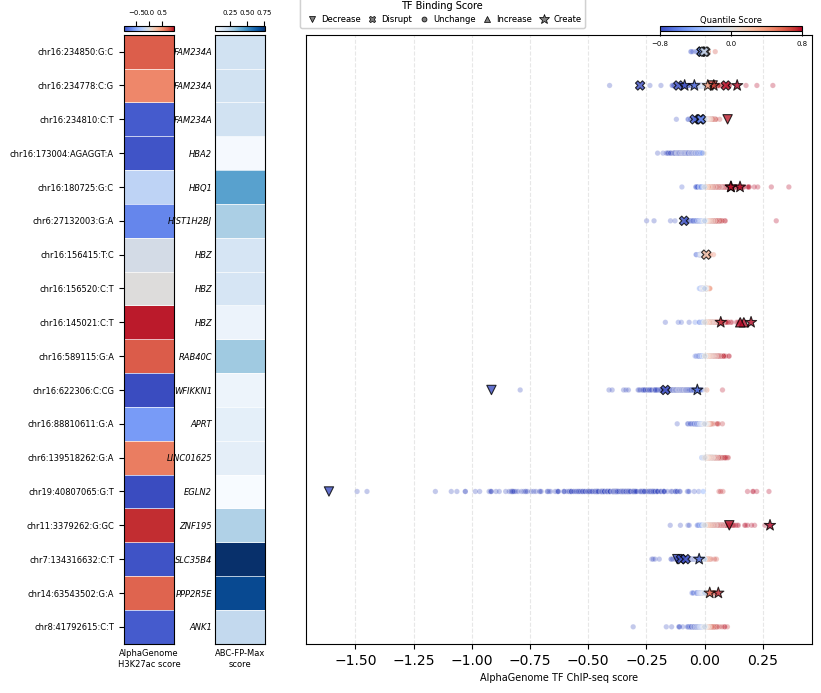

In [192]:
# === Rare variant AlphaGenome TF ChIP plot (3-panel) ===
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

n_rv = len(rv_row_order)

fig, axes = plt.subplots(1, 3, figsize=(8, 7),
                         gridspec_kw={'width_ratios': [0.5, 0.5, 5],
                                      'wspace': 0.2})

# --- Panel 0: AlphaGenome H3K27ac heatmap ---
vals0 = heatmap_h3k27ac_rv.values
vmax0 = np.nanmax(np.abs(vals0))
im0 = axes[0].imshow(vals0, cmap='coolwarm', aspect='auto', origin='lower',
                      interpolation='nearest', vmin=-vmax0, vmax=vmax0)
for i in range(n_rv + 1):
    axes[0].axhline(i - 0.5, color='white', linewidth=0.5)
axes[0].set_yticks(range(n_rv))
axes[0].set_yticklabels([r.split('(')[1].rstrip(')') for r in rv_row_order], fontsize=6)
axes[0].set_xticks([])
axes[0].set_xlabel('AlphaGenome\nH3K27ac score', fontsize=6)
axes[0].set_ylim(-0.5, n_rv - 0.5)
axes[0].set_ylabel('')

# --- Panel 1: ABC-FP-Max score heatmap ---
vals1 = heatmap_abc_rv.values
im1 = axes[1].imshow(vals1, cmap='Blues', aspect='auto', origin='lower',
                      interpolation='nearest')
for i in range(n_rv + 1):
    axes[1].axhline(i - 0.5, color='white', linewidth=0.5)
gene_labels_rv = [r.split(' (')[0] for r in rv_row_order]
axes[1].set_yticks(range(n_rv))
axes[1].set_yticklabels(gene_labels_rv, fontsize=6)
for label in axes[1].get_yticklabels():
    label.set_fontstyle('italic')
axes[1].tick_params(axis='y', length=0, pad=2)
axes[1].set_xticks([])
axes[1].set_xlabel('ABC-FP-Max\nscore', fontsize=6)
axes[1].set_ylim(-0.5, n_rv - 0.5)

# --- Panel 2: AlphaGenome TF ChIP-seq scatter ---
norm_q = Normalize(vmin=-1.0, vmax=1.0)
sns.scatterplot(data=no_change_rv, y='label', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='o', s=15, ax=axes[2], alpha=0.3, legend=False)
sns.scatterplot(data=decreased_rv, y='label', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='v', s=45, ax=axes[2], alpha=0.8, linewidth=0.8,
                edgecolors='black', legend=False)
sns.scatterplot(data=increased_rv, y='label', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='^', s=45, ax=axes[2], alpha=0.8, linewidth=0.8,
                edgecolors='black', legend=False)
sns.scatterplot(data=disrupted_rv, y='label', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='X', s=45, ax=axes[2], alpha=0.8, linewidth=0.8,
                edgecolors='black', legend=False)
sns.scatterplot(data=created_rv, y='label', x='alphag_TF_chip_score',
                hue='alphag_TF_chip_quantile', palette='coolwarm', hue_norm=norm_q,
                marker='*', s=70, ax=axes[2], alpha=0.8, linewidth=0.8,
                edgecolors='black', legend=False)
axes[2].grid(axis='x', linestyle='--', alpha=0.3)
axes[2].set_ylabel('')
axes[2].set_yticks([])
axes[2].set_ylim(-0.5, n_rv - 0.5)
axes[2].set_xlabel('AlphaGenome TF ChIP-seq score', fontsize=7)

# === Layout, then add colorbars & legends ===
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.06, top=0.93, wspace=0.08)

# --- Colorbars directly above heatmaps ---
pos0 = axes[0].get_position()
cax0 = fig.add_axes([pos0.x0, pos0.y1 + 0.005, pos0.width, 0.008])
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal')
cax0.xaxis.set_ticks_position('top')
cax0.tick_params(labelsize=5)

pos1 = axes[1].get_position()
cax1 = fig.add_axes([pos1.x0, pos1.y1 + 0.005, pos1.width, 0.008])
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position('top')
cax1.tick_params(labelsize=5)

# --- TF binding change legend ---
tf_handles = [
    Line2D([0], [0], marker='v', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=5, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=5, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=3.5, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=5, linestyle='', markeredgewidth=0.5),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='grey',
           markeredgecolor='black', markersize=7, linestyle='', markeredgewidth=0.5),
]
leg_tf = axes[2].legend(tf_handles, ['Decrease', 'Disrupt', 'Unchange', 'Increase', 'Create'],
                        title='TF Binding Score', loc='lower left',
                        bbox_to_anchor=(-0.02, 1.005), ncol=5, fontsize=6,
                        title_fontsize=7, frameon=True, handletextpad=0.1,
                        columnspacing=0.4)
axes[2].add_artist(leg_tf)

# Quantile Score colorbar
pos2 = axes[2].get_position()
cax_q = fig.add_axes([pos2.x0 + pos2.width * 0.7, pos2.y1 + 0.005, pos2.width * 0.28, 0.008])
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=Normalize(vmin=-0.8, vmax=0.8))
sm.set_array([])
cb_q = fig.colorbar(sm, cax=cax_q, orientation='horizontal')
cb_q.set_ticks([-0.8, 0, 0.8])
cax_q.tick_params(labelsize=5)
cax_q.set_title('Quantile Score', fontsize=6, pad=2)

plt.savefig(os.path.join(FIG_DIR, 'rarevar_alphag_tf_chip.pdf'),
            transparent=True, format='pdf', bbox_inches='tight')
plt.show()

In [197]:
alphag_rv_pred['label'] = pd.Categorical(alphag_rv_pred['label'], categories=rv_row_order[::-1], ordered=True)
alphag_rv_pred['alphag_TF_chip_quantile_abs'] = alphag_rv_pred['alphag_TF_chip_quantile'].abs()
alphag_rv_pred.dropna(subset=['TF_motif']).sort_values(['label', 'alphag_TF_chip_quantile_abs', 'TF_alphag_K562_rna_tpm'])

,rsID,TF_motif,TF_change,TF_alphag,TF_alphag_K562_rna_tpm,alphag_TF_chip_score,alphag_TF_chip_quantile,label,alphag_TF_chip_quantile_abs
4291,DRAGEN:chr16:234850:G:C,TFAP4::ETV1,Disrupt,ETV1,0.717459,0.003280,0.034594,FAM234A (chr16:234850:G:C),0.034594
4499,DRAGEN:chr16:234850:G:C,ETV5::FIGLA,Disrupt,ETV5,3.426730,-0.001982,-0.171333,FAM234A (chr16:234850:G:C),0.171333
3052,DRAGEN:chr16:234850:G:C,TFAP4::ETV1,Disrupt,TFAP4,5.255150,-0.013191,-0.353249,FAM234A (chr16:234850:G:C),0.353249
3154,DRAGEN:chr16:234850:G:C,ZFX,Disrupt,ZFX,1.521600,-0.011923,-0.686934,FAM234A (chr16:234850:G:C),0.686934
2971,DRAGEN:chr16:234778:C:G,ETS1,Create,ETS1,0.024958,0.013933,0.494645,FAM234A (chr16:234778:C:G),0.494645
1485,DRAGEN:chr16:234778:C:G,ZBTB7A,Create,ZBTB7A,2.118610,-0.043751,-0.840483,FAM234A (chr16:234778:C:G),0.840483
1601,DRAGEN:chr16:234778:C:G,ETV5,Create,ETV5,3.426730,0.039658,0.847126,FAM234A (chr16:234778:C:G),0.847126
1768,DRAGEN:chr16:234778:C:G,ETV6,Decrease,ETV6,1.035200,0.034810,0.853515,FAM234A (chr16:234778:C:G),0.853515
515,DRAGEN:chr16:234778:C:G,ZNF281,Disrupt,ZNF281,2.255420,-0.112579,-0.970426,FAM234A (chr16:234778:C:G),0.970426
711,DRAGEN:chr16:234778:C:G,SP1,Disrupt,SP1,4.276220,0.091800,0.975904,FAM234A (chr16:234778:C:G),0.975904


In [214]:
# === Rare variant TFBS changes NOT scored by AlphaGenome TF ChIP ===

# AlphaGenome K562 TF names (already loaded in alphag_rv)
alphag_tfs_rv = set(
    alphag_rv[
        (alphag_rv['output_type'] == 'CHIP_TF') &
        (alphag_rv['variant_scorer'].str.contains('DIFF_LOG2_SUM', na=False))
    ]['transcription_factor'].str.upper().unique()
)
print(f'AlphaGenome K562 TFs: {len(alphag_tfs_rv)}')

# Load rarevar2grn (already loaded as grn_rv)
print(f'rarevar2grn: {len(grn_rv):,} rows, {grn_rv["rsID"].nunique()} variants')

# Filter to affected TF changes only
affected_rv = grn_rv[grn_rv['TF_change'] != 'Unchange'].copy()

# Check if ALL component TFs are missing from AlphaGenome
def all_components_missing_rv(tf_name):
    components = tf_name.split('::')
    return all(comp.upper() not in alphag_tfs_rv for comp in components)

affected_rv = affected_rv[affected_rv['TF'].apply(all_components_missing_rv)].copy()
print(f'Affected rows with TF not in AlphaGenome: {len(affected_rv):,}')

# Deduplicate: keep one row per (rsID, TargetGene) — keep top ABC.Score.FP
affected_rv = affected_rv.sort_values('ABC.Score.FP', ascending=False).drop_duplicates(
    subset=['rsID', 'TargetGene'], keep='first'
).reset_index(drop=True)
print(f'After dedup per (rsID, TargetGene): {len(affected_rv):,} rows, {affected_rv["rsID"].nunique()} variants')

# Parse genome position from DRAGEN rsID for sorting
def _dragen_sort_key_rv(rsid):
    parts = rsid.split(':')
    chrom_str = parts[1].replace('chr', '')
    chrom_num = int(chrom_str) if chrom_str.isdigit() else (23 if chrom_str == 'X' else 24)
    pos = int(parts[2])
    return chrom_num, pos

affected_rv['_chrom'] = affected_rv['rsID'].apply(lambda x: _dragen_sort_key_rv(x)[0])
affected_rv['_pos'] = affected_rv['rsID'].apply(lambda x: _dragen_sort_key_rv(x)[1])

# Select and order columns (adapted for rare variant fields)
col_order_rv = [
    'rsID', 'Chromosome', 'Position', 'REF', 'ALT',
    'TF', 'TF_change', 'p-value_ref', 'p-value_alt', 'TF_K562_rna_tpm',
    'TargetGene', 'ABC.Score.FP',
]
out_rv = affected_rv[col_order_rv + ['_chrom', '_pos']].sort_values(
    ['_chrom', '_pos', 'TF'], ascending=[True, True, True]
).drop(columns=['_chrom', '_pos']).reset_index(drop=True)

out_path_rv = os.path.join(RESULTS_DIR, 'K562_rarevar_var2tfbsExtra.csv')
out_rv.to_csv(out_path_rv, index=False)

print(f'\n=== Summary ===')
print(f'Output: {out_path_rv}')
print(f'Rows: {len(out_rv):,}')
print(f'Unique variants: {out_rv["rsID"].nunique():,}')
print(f'Unique TFs: {out_rv["TF"].nunique():,}')
print(f'\nTF_change distribution:')
print(out_rv['TF_change'].value_counts().to_string())
print(f'\nTop 10 TFs by frequency:')
print(out_rv['TF'].value_counts().head(10).to_string())

out_rv

AlphaGenome K562 TFs: 269
rarevar2grn: 609 rows, 19 variants
Affected rows with TF not in AlphaGenome: 438
After dedup per (rsID, TargetGene): 19 rows, 19 variants

=== Summary ===
Output: ./results/K562_rarevar_var2tfbsExtra.csv
Rows: 19
Unique variants: 19
Unique TFs: 18

TF_change distribution:
TF_change
Disrupt     9
Create      7
Increase    2
Decrease    1

Top 10 TFs by frequency:
TF
SP2       2
ESR2      1
ZNF324    1
ZNF320    1
EPAS1     1
PLAGL2    1
PRDM9     1
PLAG1     1
EGR3      1
RARA      1


,rsID,Chromosome,Position,REF,ALT,TF,TF_change,p-value_ref,p-value_alt,TF_K562_rna_tpm,TargetGene,ABC.Score.FP
0,DRAGEN:chr6:27132003:G:A,chr6,27132003,G,A,SP2,Disrupt,0.000046,NaN,1.692150,HIST1H2BJ,0.277633
1,DRAGEN:chr6:139518262:G:A,chr6,139518262,G,A,ESR2,Disrupt,0.000064,NaN,0.307199,LINC01625,0.102923
2,DRAGEN:chr7:134316632:C:T,chr7,134316632,C,T,KLF7,Disrupt,0.000015,NaN,0.011631,SLC35B4,0.768990
3,DRAGEN:chr8:41792615:C:T,chr8,41792615,C,T,PATZ1,Decrease,0.000031,0.000075,0.652006,ANK1,0.224607
4,DRAGEN:chr11:3379262:G:GC,chr11,3379262,G,GC,KLF11,Create,NaN,0.000008,1.337600,ZNF195,0.268307
5,DRAGEN:chr14:63543502:G:A,chr14,63543502,G,A,E2F7,Create,NaN,0.000053,0.747111,PPP2R5E,0.695764
6,DRAGEN:chr16:145021:C:T,chr16,145021,C,T,PPARG::RXRA,Increase,0.000048,0.000002,2.033680,HBZ,0.074122
7,DRAGEN:chr16:156415:T:C,chr16,156415,T,C,ESRRG,Disrupt,0.000080,NaN,0.009694,HBZ,0.155316
8,DRAGEN:chr16:156520:C:T,chr16,156520,C,T,PITX2,Increase,0.000061,0.000046,0.000000,HBZ,0.155316
9,DRAGEN:chr16:173004:AGAGGT:A,chr16,173004,AGAGGT,A,RARA,Disrupt,0.000045,NaN,1.411080,HBA2,0.040638


In [209]:
def _dragen_sort_key(rsid):
    """Extract (chrom_num, pos) from DRAGEN:chrN:POS:REF:ALT for sorting."""
    parts = rsid.split(':')
    chrom_str = parts[1].replace('chr', '')
    chrom_num = int(chrom_str) if chrom_str.isdigit() else (23 if chrom_str == 'X' else 24)
    pos = int(parts[2])
    return (chrom_num, pos)

alphag_rv_pred = alphag_rv_pred.assign(
    _chrom=alphag_rv_pred['rsID'].apply(lambda x: _dragen_sort_key(x)[0]),
    _pos=alphag_rv_pred['rsID'].apply(lambda x: _dragen_sort_key(x)[1]),
)
alphag_rv_pred.sort_values(['_chrom', '_pos', 'TF_alphag'], inplace=True)
alphag_rv_pred.drop(columns=['_chrom', '_pos'], inplace=True)
alphag_rv_pred.reset_index(drop=True)

,rsID,TF_motif,TF_change,TF_alphag,TF_alphag_K562_rna_tpm,alphag_TF_chip_score,alphag_TF_chip_quantile,label,alphag_TF_chip_quantile_abs
0,DRAGEN:chr6:27132003:G:A,None,None,ADNP,1.274160,0.022840,0.777192,HIST1H2BJ (chr6:27132003:G:A),0.777192
1,DRAGEN:chr6:27132003:G:A,None,None,AFF1,3.527530,0.014674,0.584379,HIST1H2BJ (chr6:27132003:G:A),0.584379
2,DRAGEN:chr6:27132003:G:A,None,None,AFF4,2.696820,0.004504,0.259272,HIST1H2BJ (chr6:27132003:G:A),0.259272
3,DRAGEN:chr6:27132003:G:A,None,None,AGO1,4.911780,-0.019285,-0.468060,HIST1H2BJ (chr6:27132003:G:A),0.468060
4,DRAGEN:chr6:27132003:G:A,None,None,ARID1B,0.850078,-0.020411,-0.748275,HIST1H2BJ (chr6:27132003:G:A),0.748275
...,...,...,...,...,...,...,...,...,...
4837,DRAGEN:chr19:40807065:G:T,None,None,ZNF740,2.696790,-0.407320,-0.999363,EGLN2 (chr19:40807065:G:T),0.999363
4838,DRAGEN:chr19:40807065:G:T,None,None,ZNF766,1.092490,-0.327473,-0.997839,EGLN2 (chr19:40807065:G:T),0.997839
4839,DRAGEN:chr19:40807065:G:T,None,None,ZNF778,8.833150,-0.189068,-0.998161,EGLN2 (chr19:40807065:G:T),0.998161
4840,DRAGEN:chr19:40807065:G:T,None,None,ZNF83,3.655130,-0.203900,-0.996156,EGLN2 (chr19:40807065:G:T),0.996156


In [217]:
def plot_manhattan(ax, df, title, threshold=5e-8, ymax=None, sign='LOG10P', colors = ['skyblue', 'navy']):
    # colors = ['skyblue', 'navy'] 
    # Work on a copy so the original DataFrame is not modified
    df_plot = df.copy()
    df_plot['BP_cum'] = 0
    chrom_order = sorted(df_plot['CHROM'].unique(), key=lambda x: int(x))
    cum_bp = 0
    ticks = []
    labels = []
    for chrom in chrom_order:
        mask = df_plot['CHROM'] == chrom
        # Compute cumulative base pair positions
        df_plot.loc[mask, 'BP_cum'] = df_plot.loc[mask, 'GENPOS'] + cum_bp
        ticks.append(df_plot.loc[mask, 'BP_cum'].median())
        labels.append(chrom)
        cum_bp += df_plot.loc[mask, 'GENPOS'].max()
    
    # Plot points for each chromosome using alternating colors
    for i, chrom in enumerate(chrom_order):
        chrom_data = df_plot[df_plot['CHROM'] == chrom]
        # chrom_data_high_pip = chrom_data[chrom_data['PIP'] > 0.8]
        ax.scatter(chrom_data['BP_cum'], chrom_data[sign],
                   color=colors[i % len(colors)],
                   s=5, label=f'Chr {chrom}')
        # ax.scatter(chrom_data_high_pip['BP_cum'], chrom_data_high_pip[sign],
        #            color='green',
        #            s=5, label=f'Chr {chrom}')
    
    # ax.set_xlabel('Chromosome')
    ax.set_ylabel(sign)
    # ax.set_title(title)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    # Draw a significance threshold line (e.g., p-value = 5e-8)
    if threshold is not None:
        ax.axhline(threshold, color='red', linestyle='dashed', lw=1)
    ax.margins(x=0.01, y=0.02)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    # Remove unwanted spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # if ymax is not None:
    #     plt.ylim(0, ymax)

100%|██████████| 13/13 [02:13<00:00, 10.25s/it]


Filtered out 3 footprints with max MAC <= 30: ['chr16:172966-172981', 'chr17:42798734-42798761', 'chr9:112487722-112487736']


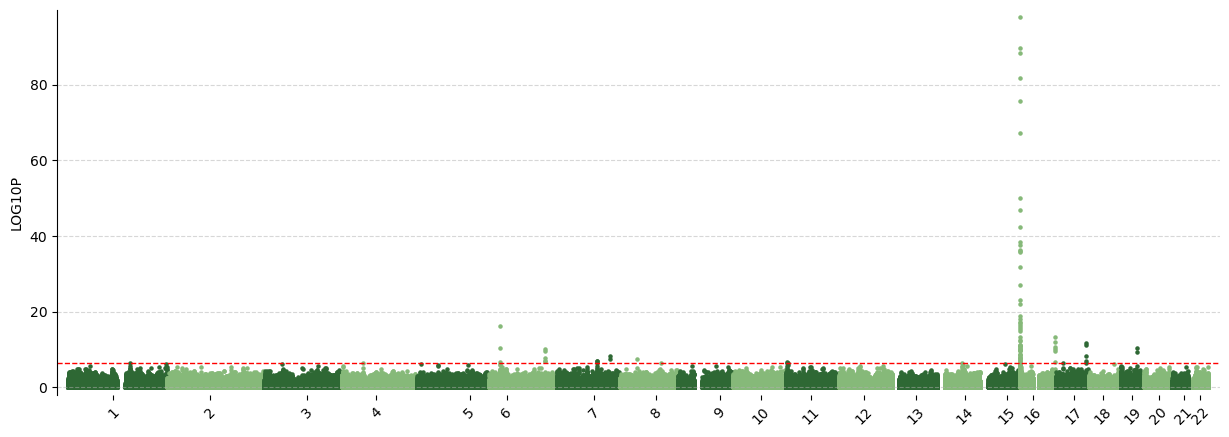

In [224]:
cell = 'K562'
all_rare_K562 = []
for trait in tqdm(erythroid_traits):
    rare_vars = pd.read_excel('data/burdentest_erythroids/{}.{}_FOODIE_fps_rare_var_result.2025-05-29.xlsx'.format(trait, cell))
    rare_vars['trait'] = trait
    all_rare_K562.append(rare_vars)
all_rare_K562 = pd.concat(all_rare_K562).reset_index(drop=True)
foodie_bed = pr.read_bed('data/FOODIE_footprints/{}.merged.hg38.bed'.format(cell))

# Filter out footprints where no LOO variant has MAC > 30 (no identifiable driver)
loo = pd.read_csv('data/leaveoneout_results/K562.leave_one_out.all_traits.20251120.csv')
low_mac_fps = set(loo.groupby('foodie')['MAC_rare'].max().pipe(lambda s: s[s <= 30]).index)
all_rare_K562_filt = all_rare_K562[~all_rare_K562['ID'].isin(low_mac_fps)].reset_index(drop=True)
print(f'Filtered out {len(low_mac_fps)} footprints with max MAC <= 30: {sorted(low_mac_fps)}')

fig, ax1 = plt.subplots(nrows=1, figsize=(15, 5), sharex=True)
colors = ['#2e6834', '#86b979']
plot_manhattan(ax1, all_rare_K562_filt, 'rare variants', sign='LOG10P', threshold=-np.log10(0.05/len(foodie_bed)), colors=colors)
# plt.savefig('./K562_rare_erythroid_traits.png', dpi=400, transparent=True)

In [231]:
# === Significant footprint-gene pairs from rare variant burden test ===
import pyranges as pr

# Bonferroni threshold
foodie_bed_df = pd.read_csv('data/FOODIE_footprints/K562.merged.hg38.bed', sep='\t',
                            header=None, names=['chrom','start','end','name','score','strand'])
threshold = -np.log10(0.05 / len(foodie_bed_df))
print(f'Bonferroni threshold (LOG10P): {threshold:.2f}')

# Filter significant footprints across all traits
sig_fps = all_rare_K562[all_rare_K562['LOG10P'] >= threshold].copy()
print(f'Significant footprint-trait pairs: {len(sig_fps):,}')
print(f'Unique significant footprints: {sig_fps["ID"].nunique()}')

# Parse footprint coordinates from ID (e.g. chr16:234807-234822)
sig_fps[['fp_chrom', '_range']] = sig_fps['ID'].str.split(':', expand=True)
sig_fps[['fp_start', 'fp_end']] = sig_fps['_range'].str.split('-', expand=True).astype(int)

# Build PyRanges for significant footprints (unique)
sig_fp_unique = sig_fps.drop_duplicates('ID')[['fp_chrom', 'fp_start', 'fp_end', 'ID']].copy()
sig_fp_unique.columns = ['Chromosome', 'Start', 'End', 'fp_id']
sig_fp_pr = pr.PyRanges(sig_fp_unique)

# Load ABC enhancer regions
enh = pd.read_csv('data/ABC_FP_results/K562_FOODIE_ATAC/Neighborhoods/EnhancerList.bed',
                   sep='\t', header=None, names=['Chromosome', 'Start', 'End', 'enh_name'])
enh_pr = pr.PyRanges(enh)

# Overlap: find which enhancer contains each significant footprint
overlap = sig_fp_pr.join(enh_pr, how='left').df
print(f'Footprint-enhancer overlaps: {len(overlap)}')

# Load ABC predictions (significant: ABC.Score > 0.015)
abc = pd.read_csv('data/ABC_FP_results/K562_FOODIE_ATAC/Predictions/EnhancerPredictionsAllPutative.tsv.gz',
                   sep='\t', usecols=['name', 'TargetGene', 'ABC.Score', 'distance', 'isSelfPromoter', 'class'])
abc_sig = abc[abc['ABC.Score'] > 0.015].copy()

# Merge footprint → enhancer → gene (left join to keep footprints without gene links)
fp_gene = overlap.merge(abc_sig, left_on='enh_name', right_on='name', how='left')
fp_gene = fp_gene[['fp_id', 'enh_name', 'class', 'TargetGene', 'ABC.Score', 'distance', 'isSelfPromoter']].copy()

# Keep only the gene with max ABC.Score per footprint
fp_gene = fp_gene.sort_values('ABC.Score', ascending=False).drop_duplicates(
    subset=['fp_id'], keep='first'
).reset_index(drop=True)

# Trait info per footprint
trait_info = sig_fps.groupby('ID').agg(
    traits=('trait', lambda x: ','.join(sorted(x.unique()))),
    max_LOG10P=('LOG10P', 'max'),
    n_traits=('trait', 'nunique'),
    footprint_MAC=('MAC', 'max'),
).reset_index().rename(columns={'ID': 'fp_id'})

fp_gene = fp_gene.merge(trait_info, on='fp_id', how='left')

# Add LOO max MAC per footprint (max MAC of individual rare variants within footprint)
loo = pd.read_csv('data/leaveoneout_results/K562.leave_one_out.all_traits.20251120.csv')
loo_mac = loo.groupby('foodie')['MAC_rare'].max().rename('max_variant_MAC')
fp_gene = fp_gene.merge(loo_mac, left_on='fp_id', right_index=True, how='left')

# Add driver variant info
drivers = pd.read_csv(os.path.join(RESULTS_DIR, 'rarevar_var2tfbs_results', 'driver_variants_summary.csv'))
driver_by_fp = drivers.drop_duplicates('footprint')[['footprint', 'driver_variant', 'driver_MAC']]
fp_gene = fp_gene.merge(driver_by_fp, left_on='fp_id', right_on='footprint', how='left').drop(columns='footprint')

# Add K562 gene expression (TPM, summed across transcripts)
gene_expr = pd.read_csv('data/gene_expr/K562_ENCFF485RIA_gene.tsv', sep='\t')
gene_tpm = gene_expr.groupby('gene_name')['tpm'].sum().rename('K562_TPM')
fp_gene = fp_gene.merge(gene_tpm, left_on='TargetGene', right_index=True, how='left')

# Reorder columns
fp_gene = fp_gene[['fp_id', 'TargetGene', 'ABC.Score', 'class', 'K562_TPM', 'max_LOG10P', 'n_traits', 'traits',
                    'footprint_MAC', 'max_variant_MAC', 'driver_variant', 'driver_MAC']].copy()

print(f'\nUnique footprints: {fp_gene["fp_id"].nunique()}')
print(f'  with gene link (ABC > 0.015): {fp_gene["TargetGene"].notna().sum()}')
print(f'  without gene link: {fp_gene["TargetGene"].isna().sum()}')
print(f'  with driver variant: {fp_gene["driver_variant"].notna().sum()}')
print(f'  without driver (MAC<=30): {fp_gene["driver_variant"].isna().sum()}')

fp_gene.sort_values('max_LOG10P', ascending=False).reset_index(drop=True)

Bonferroni threshold (LOG10P): 6.58
Significant footprint-trait pairs: 80
Unique significant footprints: 24
Footprint-enhancer overlaps: 24

Unique footprints: 24
  with gene link (ABC > 0.015): 23
  without gene link: 1
  with driver variant: 21
  without driver (MAC<=30): 3


,fp_id,TargetGene,ABC.Score,class,K562_TPM,max_LOG10P,n_traits,traits,footprint_MAC,max_variant_MAC,driver_variant,driver_MAC
0,chr16:234776-234784,FAM234A,1.000000,promoter,5.219610,97.83150,8,"HC,MCH,MCHC,MCV,MSCV,RBC,RBCDW,RP",566,543.0,DRAGEN:chr16:234778:C:G,543.0
1,chr16:234807-234822,FAM234A,1.000000,promoter,5.219610,89.74950,6,"MCH,MCHC,MCV,MSCV,RBC,RBCDW",623,491.0,DRAGEN:chr16:234810:C:T,491.0
2,chr16:234844-234852,FAM234A,1.000000,promoter,5.219610,75.64840,6,"MCH,MCHC,MCV,MSCV,RBC,RBCDW",784,611.0,DRAGEN:chr16:234850:G:C,611.0
3,chr16:180724-180738,HBQ1,1.000000,promoter,44.558500,42.32860,5,"MCH,MCHC,MCV,RBC,RBCDW",333,261.0,DRAGEN:chr16:180725:G:C,261.0
4,chr16:172995-173014,HBA2,1.000000,promoter,63.884533,37.56890,6,"MCH,MCHC,MCV,MSCV,RBC,RBCDW",83,53.0,DRAGEN:chr16:173004:AGAGGT:A,53.0
5,chr16:318844-318863,NaN,NaN,NaN,NaN,18.79590,4,"MCH,MCHC,MCV,RBC",282,238.0,DRAGEN:chr16:318854:T:C,238.0
6,chr16:589088-589118,RAB40C,1.000000,promoter,5.411960,17.23360,3,"MCH,MCV,RBC",507,256.0,DRAGEN:chr16:589115:G:A,256.0
7,chr6:27131998-27132010,HIST1H2AG,1.000000,promoter,376.386000,16.28040,3,"HC,MCH,MCV",627,609.0,DRAGEN:chr6:27132003:G:A,609.0
8,chr16:622303-622332,WFIKKN1,0.064428,genic,0.118702,15.95900,3,"MCH,MCV,RBC",350,182.0,DRAGEN:chr16:622306:C:CG,182.0
9,chr16:145010-145040,HBZ,0.054921,intergenic,55.352100,13.32990,4,"MCH,MCHC,MCV,RBC",761,719.0,DRAGEN:chr16:145021:C:T,719.0


In [223]:
# === Significant footprints WITHOUT a LOO driver variant ===
drivers = pd.read_csv(os.path.join(RESULTS_DIR, 'rarevar_var2tfbs_results', 'driver_variants_summary.csv'))
driver_fps = set(drivers['footprint'].unique())
print(f'Total significant footprints: {sig_fps["ID"].nunique()}')
print(f'Footprints with LOO driver: {len(driver_fps)}')

# Significant footprints that have no driver
no_driver_fps = set(sig_fps['ID'].unique()) - driver_fps
print(f'Significant footprints without driver: {len(no_driver_fps)}')

# Show footprint-gene pairs for these
fp_gene_no_driver = fp_gene[fp_gene['fp_id'].isin(no_driver_fps)].copy()
print(f'Footprint-gene pairs without driver: {len(fp_gene_no_driver)}')
print(f'Unique genes: {fp_gene_no_driver["TargetGene"].nunique()}')

fp_gene_no_driver.sort_values(['max_LOG10P', 'ABC.Score'], ascending=[False, False]).reset_index(drop=True)

Total significant footprints: 24
Footprints with LOO driver: 21
Significant footprints without driver: 3
Footprint-gene pairs without driver: 10
Unique genes: 10


,fp_id,enh_name,class,TargetGene,ABC.Score,distance,isSelfPromoter,traits,max_LOG10P,n_traits
0,chr16:172966-172981,promoter|chr16:172724-173440,promoter,HBA2,1.000000,236.0,True,"MCH,MCV",7.91376,2
1,chr16:172966-172981,promoter|chr16:172724-173440,promoter,HBA1,0.022624,3568.0,False,"MCH,MCV",7.91376,2
2,chr17:42798734-42798761,promoter|chr17:42798467-42798997,promoter,CNTD1,1.000000,103.0,True,MCV,7.83415,1
3,chr17:42798734-42798761,promoter|chr17:42798467-42798997,promoter,COA3,1.000000,7.0,True,MCV,7.83415,1
4,chr17:42798734-42798761,promoter|chr17:42798467-42798997,promoter,WNK4,0.032392,18102.0,False,MCV,7.83415,1
5,chr17:42798734-42798761,promoter|chr17:42798467-42798997,promoter,VPS25,0.029096,25297.0,False,MCV,7.83415,1
6,chr17:42798734-42798761,promoter|chr17:42798467-42798997,promoter,BECN1,0.022826,25584.0,False,MCV,7.83415,1
7,chr17:42798734-42798761,promoter|chr17:42798467-42798997,promoter,AOC3,0.018924,52451.0,False,MCV,7.83415,1
8,chr9:112487722-112487736,promoter|chr9:112486474-112487979,promoter,KIAA1958,1.000000,259.5,True,RBC,6.86735,1
9,chr9:112487722-112487736,promoter|chr9:112486474-112487979,promoter,INIP,0.018652,230922.5,False,RBC,6.86735,1


In [ ]:
# === Pipeline Filtering Summary (Common + Rare Variants) ===

import pandas as pd, numpy as np, glob, os

RESULTS_DIR = 'results'

# ── Common Variant Pipeline ──────────────────────────────────────────────────

# 1. Total GWFM SNPs (hg38)
snpres_files = sorted(glob.glob('data/GWFM_erythroids/snpRes_hg38/*.snpRes'))
all_snps = set()
for f in snpres_files:
    df = pd.read_csv(f, sep='\t', usecols=['Name'])
    all_snps.update(df['Name'])
n_total_snps = len(all_snps)

# 2. Credible set (PIP > 0.1)
cs_files = sorted(glob.glob('data/GWFM_erythroids/credible_set_snpRes/*_credible_set_hg38.csv'))
cs_snps = set()
for f in cs_files:
    df = pd.read_csv(f, usecols=['Name'])
    cs_snps.update(df['Name'])
n_credset = len(cs_snps)

# 3. Footprint overlap
fp_bed = pd.read_csv(os.path.join(RESULTS_DIR, 'comvar_footprint_overlap_credible',
                                   'GWFM_variants_in_K562.merged.hg38.bed'),
                     sep='\t', header=None)
n_fp_overlap = fp_bed[3].nunique()

# 4. VAR2TFBS
var2tfbs = pd.read_csv(os.path.join(RESULTS_DIR, 'comvar_var2tfbs_results', 'K562_var2tfbs.csv'))
n_var2tfbs_all = var2tfbs['rsID'].nunique()
affected = var2tfbs[var2tfbs['TF_change'] != 'Unchange']
n_var2tfbs_affected = affected['rsID'].nunique()

# 5. Var-to-Gene
var2gene = pd.read_csv(os.path.join(RESULTS_DIR, 'var2gene_results', 'K562_comvar_ABC-FP-Max.csv'))
n_var2gene = var2gene['rsID'].nunique()

# 6. comvar2grn
grn = pd.read_csv(os.path.join(RESULTS_DIR, 'K562_comvar2grn.csv'))
n_grn = grn['rsID'].nunique()

# 7. comvar2grn + ABC > 0.015
grn_abc = grn[grn['ABC.Score'] > 0.015]
n_grn_abc = grn_abc['rsID'].nunique()
n_grn_abc_genes = grn_abc['TargetGene'].nunique()

comvar_summary = pd.DataFrame([
    {'Step': 'GWFM SNPs (hg38)', 'Variants': n_total_snps, 'Filter': 'All SNPs across 15 traits'},
    {'Step': 'Credible set', 'Variants': n_credset, 'Filter': 'PIP > 0.1 (13 erythroid traits)'},
    {'Step': 'Footprint overlap', 'Variants': n_fp_overlap, 'Filter': 'Inside K562 FOODIE footprint'},
    {'Step': 'VAR2TFBS (FIMO hit)', 'Variants': n_var2tfbs_all, 'Filter': 'Variant in TF motif'},
    {'Step': 'VAR2TFBS (TF changed)', 'Variants': n_var2tfbs_affected, 'Filter': 'Create/Disrupt/Increase/Decrease'},
    {'Step': 'Var-to-Gene', 'Variants': n_var2gene, 'Filter': 'ABC-FP-Max gene assignment'},
    {'Step': 'comvar2grn', 'Variants': n_grn, 'Filter': 'Credible set (PEP_cs not NaN)'},
    {'Step': 'comvar2grn (final)', 'Variants': n_grn_abc, 'Filter': '+ ABC.Score > 0.015'},
])
comvar_summary['Genes'] = ['', '', '', '', '', str(var2gene['TargetGene'].nunique()),
                           str(grn['TargetGene'].nunique()), str(n_grn_abc_genes)]

# ── Rare Variant Pipeline ────────────────────────────────────────────────────

# 1. Total footprints
foodie_bed = pd.read_csv('data/FOODIE_footprints/K562.merged.hg38.bed', sep='\t', header=None)
n_total_fps = len(foodie_bed)
threshold = -np.log10(0.05 / n_total_fps)

# 2. Significant footprints from burden test
erythroid_traits = sorted([os.path.basename(f).split('.')[0]
    for f in glob.glob('data/burdentest_erythroids/*.K562_FOODIE_fps_rare_var_result.*.xlsx')])
all_rare = []
for trait in erythroid_traits:
    f = glob.glob(f'data/burdentest_erythroids/{trait}.K562_FOODIE_fps_rare_var_result.*.xlsx')[0]
    df = pd.read_excel(f)
    df['trait'] = trait
    all_rare.append(df)
all_rare = pd.concat(all_rare)
sig_fps = all_rare[all_rare['LOG10P'] >= threshold]
n_sig_fps = sig_fps['ID'].nunique()

# 3. MAC > 30 filter
loo = pd.read_csv('data/leaveoneout_results/K562.leave_one_out.all_traits.20251120.csv')
fp_max_mac = loo.groupby('foodie')['MAC_rare'].max()
low_mac_fps = set(fp_max_mac[fp_max_mac <= 30].index)
sig_fp_ids = set(sig_fps['ID'].unique())
n_mac30_fps = len(sig_fp_ids - low_mac_fps)

# 4. Driver variants
drivers = pd.read_csv(os.path.join(RESULTS_DIR, 'rarevar_var2tfbs_results', 'driver_variants_summary.csv'))
n_drivers = drivers['driver_variant'].nunique()
n_driver_fps = drivers['footprint'].nunique()

# 5. VAR2TFBS
rv_var2tfbs = pd.read_csv(os.path.join(RESULTS_DIR, 'rarevar_var2tfbs_results', 'K562_rarevar_var2tfbs.csv'))
n_rv_var2tfbs = rv_var2tfbs['rsID'].nunique()

# 6. Var-to-Gene
rv_var2gene = pd.read_csv(os.path.join(RESULTS_DIR, 'var2gene_results', 'K562_rarevar_ABC-FP-Max.csv'))
n_rv_var2gene = rv_var2gene['rsID'].nunique()

# 7. rarevar2grn
rv_grn = pd.read_csv(os.path.join(RESULTS_DIR, 'K562_rarevar2grn.csv'))
n_rv_grn = rv_grn['rsID'].nunique()
n_rv_grn_genes = rv_grn['TargetGene'].nunique()

rarevar_summary = pd.DataFrame([
    {'Step': 'K562 FOODIE footprints', 'Variants': n_total_fps, 'Filter': 'All footprints tested'},
    {'Step': 'Significant footprints', 'Variants': n_sig_fps, 'Filter': f'Burden test Bonferroni (p < {0.05/n_total_fps:.2e})'},
    {'Step': 'MAC > 30 footprints', 'Variants': n_mac30_fps, 'Filter': 'At least one LOO variant with MAC > 30'},
    {'Step': 'Driver variants (LOO)', 'Variants': n_drivers, 'Filter': f'Best LOO variant per footprint ({n_driver_fps} footprints)'},
    {'Step': 'VAR2TFBS (FIMO hit)', 'Variants': n_rv_var2tfbs, 'Filter': 'Variant in TF motif'},
    {'Step': 'Var-to-Gene (ABC > 0.015)', 'Variants': n_rv_var2gene, 'Filter': 'ABC-FP-Max gene assignment'},
    {'Step': 'rarevar2grn (final)', 'Variants': n_rv_grn, 'Filter': 'Full linkage table'},
])
rarevar_summary['Genes'] = ['', '', '', '', '',
                             str(rv_var2gene['TargetGene'].nunique()),
                             str(n_rv_grn_genes)]

print('=== Common Variant Filtering Summary ===')
print(comvar_summary.to_string(index=False))
print(f'\nFinal: {n_grn_abc} variants → {n_grn_abc_genes} target genes')

print(f'\n=== Rare Variant Filtering Summary ===')
print(rarevar_summary.to_string(index=False))
print(f'\nFinal: {n_rv_grn} variants → {n_rv_grn_genes} target genes')

# Save both summaries
with pd.ExcelWriter(os.path.join(RESULTS_DIR, 'filtering_summary.xlsx')) as writer:
    comvar_summary.to_excel(writer, sheet_name='Common Variants', index=False)
    rarevar_summary.to_excel(writer, sheet_name='Rare Variants', index=False)
print(f'\nSaved to results/filtering_summary.xlsx')